In [ ]:
!pip install mendelai-brat-parser
!pip install stc

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import regex as re
from collections import Counter
import math

from google.colab import files
import zipfile
import glob

from brat_parser import get_entities_relations_attributes_groups

from nltk.tag import pos_tag, map_tag

from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from brat_parser import get_entities_relations_attributes_groups

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from stc import SparseTensorClassifier
from scipy.stats import spearmanr

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score, precision_score

In [ ]:
# Neural network imports.
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input, Dropout
from keras.layers import TimeDistributed
from keras.layers import Concatenate
from keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Input

# **Relations Dataframe**

In [ ]:
# Import the datataset, created in a previous moment, (essay_relation_dataset.csv) 
# containing an entry for each relation of the Stab and Gurevych dataset.
# Each entry is composed as: 
# (type,doc_id,supporting_text,supporting_type,supporting_sentence_id,supporting_section_length,supported_text,supported_type,supported_sentence_id,supported_section_length)
# where type is the relation tipe (attack, support, none).
# supporting and supported refer to the two section of the corpus that are in a relation:
# text refers to their original texts, type if they are a premise or a claim, the length to the number of sentences in the arg. section after the first one,  and sentence_id
# indicates the position in the corpus of the sentence that contains them.
print('\nImport essay_relation_dataset.csv\n')
uploaded = files.upload()


Import essay_relation_dataset.csv



Saving essay_relation_dataset.csv to essay_relation_dataset.csv


In [ ]:
# Import the statistics and positions information of the sentences to classify.
print('\nImport relation_statistic.csv\n')
upload = files.upload()

# Import the BOW of the bigrams of the sentences to classify.
print('\nImport relation_Bigram.csv\n')
upload = files.upload()

# Import the BOW of the dependency tag of the sentences to classify.
print('\nImport relation_dependency.csv\n')
upload = files.upload()

# Import the statistic relative to the tree of the dependency tag of the sentences to classify.
print('\nImport relation_dependency_tree_stat.csv\n')
upload = files.upload()

# Import the BOW of the POS of the sentences to classify.
print('\nImport relation_POS.csv\n')
upload = files.upload()

# Import the BOW of the simplyfied POS of the sentences to classify.
print('\nImport relation_simple_POS.csv\n')
upload = files.upload()

# Import the BOW for secific n-grams of the sentences to classify.
print('\nImport relation_imported_ngram.csv\n')
upload = files.upload()

# Import the remaining statistics of the sentences to classify.
print('\nImport relation_remaining_stat.csv\n')
upload = files.upload()


Import relation_statistic.csv




Import relation_Bigram.csv




Import relation_dependency.csv




Import relation_dependency_tree_stat.csv




Import relation_POS.csv




Import relation_simple_POS.csv




Import relation_imported_ngram.csv




Import relation_remaining_stat.csv



In [ ]:
# Import the feature relative to the labeled named entity of the sentences not to use.
# (drop_claim_premise_named_entity.txt).
print('\nImport drop_relation_named_entity.txt\n')
upload = files.upload()

# Import the feature relative to the Dependency tag of the sentences not to use.
# (drop_claim_premise_named_entity.txt).
print('\nImport drop_relation_dependency.txt\n')
upload = files.upload()


Import drop_relation_named_entity.txt




Import drop_relation_dependency.txt



In [ ]:
# Import the original Stab and Gurevych dataset (2017 version).

uploaded = files.upload()

Saving ArgumentAnnotatedEssays-2.0.zip to ArgumentAnnotatedEssays-2.0.zip


In [ ]:
# The imported dataset is here directly used.
# MajorClaim have been removed from the argumentations in the imported dataset (they don't have labeled relations).

relation_ann_dataset=pd.read_csv('essay_relation_dataset.csv')

In [ ]:
relation_ann_dataset.head()

,type,doc_id,supporting_text,supporting_type,supporting_sentence_id,supporting_section_length,supported_text,supported_type,supported_sentence_id,supported_section_length
0,supports,0,What we acquired from team work is not only ho...,Premise,5,0,"through cooperation, children can learn about ...",Claim,4,0
1,supports,0,"During the process of cooperation, children ca...",Premise,6,0,"through cooperation, children can learn about ...",Claim,4,0
2,supports,0,All of these skills help them to get on well w...,Premise,7,0,"through cooperation, children can learn about ...",Claim,4,0
3,supports,0,the significance of competition is that how to...,Premise,8,0,competition makes the society more effective,Claim,9,0
4,supports,0,when we consider about the question that how t...,Premise,10,0,"without the cooperation, there would be no vic...",Claim,14,0


In [ ]:
# Print some the dataset characteristics.
print("Informations about the dataset:\n")
print("Number element in the dataset: {}".format(len(relation_ann_dataset)))
print("Number effective relations: {}".format(len(relation_ann_dataset.loc[relation_ann_dataset['type']!='None'])))
print("Number support relations: {}".format(len(relation_ann_dataset.loc[relation_ann_dataset['type']=='supports'])))
print("Number attack relations: {}".format(len(relation_ann_dataset.loc[relation_ann_dataset['type']=='attacks'])))
print("Number premise supported by other premises: {}".format(len(relation_ann_dataset.loc[(relation_ann_dataset['supported_type']=='Premise')&(relation_ann_dataset['type']=='supports')])))

Informations about the dataset:

Number element in the dataset: 6243
Number effective relations: 3832
Number support relations: 3613
Number attack relations: 219
Number premise supported by other premises: 667


# **Original dataset**

In [ ]:
# Function to extract zip file.
# Takes in input the path to the zip file (path_zip) and the one to store the destination directory (path_destination).

def extract_zip(path_zip,path_destination):
  with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(path_destination)


In [ ]:
# Extract zip file (two zip files one inside the other).

extract_zip('ArgumentAnnotatedEssays-2.0.zip','ArgumentAnnotatedEssays-2.0')

extract_zip('ArgumentAnnotatedEssays-2.0/ArgumentAnnotatedEssays-2.0/brat-project-final.zip','ArgumentAnnotatedEssays')

# **Create and visualize the required Dataframe**

In [ ]:
# Extract the list of text files of the essays in the dataset.
txt_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.txt"))

# Extract the list of text files of the essays in the dataset.
ann_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.ann"))

In [ ]:
# List of text files of the essays.
txt_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.txt']

In [ ]:
# List of the annotated files of the essays.
ann_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.ann']

In [ ]:
# Transfor the ann files into four dictionaries.
ann_disctionaries=[get_entities_relations_attributes_groups(file) for file in ann_files]

# Transform the first dictionary (entities) obtained from each ann file into a dataset.
essay_ann_datasets = [pd.DataFrame.from_dict(entities, orient='index') for entities,_,_,_ in ann_disctionaries]

In [ ]:
# Sort the lists composed of a (entity) dataset for each essay.
essay_ann_datasets=[dataset.sort_values(by='span', key=lambda col: col.map(lambda x: x[0][0])) for dataset in essay_ann_datasets]  

# Add a coloumn into the dataset that identifies the document
for i in range(len(essay_ann_datasets)):
  essay_ann_datasets[i].insert(0,'doc_id',i)

# Create a common dataset
essay_argument_dataset = pd.concat(essay_ann_datasets)

In [ ]:
# Sobstitue the values in the "span" feature (substitute each tuple with its first inner tuple)
for i in range(len(essay_argument_dataset.index)):
  essay_argument_dataset['span'][i]=essay_argument_dataset['span'][i][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
essay_argument_dataset.head()

,doc_id,id,type,span,text
T1,0,T1,MajorClaim,"(503, 575)",we should attach more importance to cooperatio...
T3,0,T3,Claim,"(591, 714)","through cooperation, children can learn about ..."
T4,0,T4,Premise,"(716, 851)",What we acquired from team work is not only ho...
T5,0,T5,Premise,"(853, 1086)","During the process of cooperation, children ca..."
T6,0,T6,Premise,"(1088, 1191)",All of these skills help them to get on well w...


# **Word list of the Corpus**

In [ ]:
# List of texts of the essays
files_text=[open(file).read() for file in txt_files]

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "span" coloumn of the Dataframe of the annotation.

sorted_span=[list(essay_argument_dataset.loc[essay_argument_dataset['doc_id'] == i,['span','type']].values) for i in range(len(ann_files))]

In [ ]:
sorted_span[0]

[array([(503, 575), 'MajorClaim'], dtype=object),
 array([(591, 714), 'Claim'], dtype=object),
 array([(716, 851), 'Premise'], dtype=object),
 array([(853, 1086), 'Premise'], dtype=object),
 array([(1088, 1191), 'Premise'], dtype=object),
 array([(1212, 1301), 'Premise'], dtype=object),
 array([(1332, 1376), 'Claim'], dtype=object),
 array([(1387, 1492), 'Premise'], dtype=object),
 array([(1549, 1846), 'Premise'], dtype=object),
 array([(1927, 1992), 'Claim'], dtype=object),
 array([(2154, 2231), 'MajorClaim'], dtype=object)]

In [ ]:
# Tranform the couples of points ((start,end) of each section) to a list (separator of different section).

span_points=[]

for i in range(len(sorted_span)):
  list_points=[sep for sub in sorted_span[i] for sep in sub[0]]
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(files_text[i]))
  span_points.append(list_points)

In [ ]:
span_points[0]

[0,
 503,
 575,
 591,
 714,
 716,
 851,
 853,
 1086,
 1088,
 1191,
 1212,
 1301,
 1332,
 1376,
 1387,
 1492,
 1549,
 1846,
 1927,
 1992,
 2154,
 2231,
 2232]

In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(files_text)):
  split_text.append([files_text[z][i: j] for i, j in zip(span_points[z], span_points[z][1:])])

In [ ]:
split_text[0][0:10]

["Should students be taught to compete or to cooperate?\n\nIt is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that ",
 'we should attach more importance to cooperation during primary education',
 '.\nFirst of all, ',
 'through cooperation, children can learn about interpersonal skills which are significant in the future life of all students',
 '. ',
 'What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others',
 '. ',
 'During the process of cooperation, children can learn about how to listen to opinions of others, how to com

In [ ]:
# Get the list of the words of each essay.

X_essay_word_list=[]

for i in range(len(split_text)):
  
  essay_word_list=[]

  # Remove title from essay considered (splitted_text)
  no_title=[re.sub(r".*\n\n","",text) for text in split_text[i]]

  for section in no_title:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    essay_word_list+=seq

  X_essay_word_list.append(essay_word_list)

In [ ]:
X_essay_word_list[0][80:120]

['i',
 'firmly',
 'believe',
 'that',
 'we',
 'should',
 'attach',
 'more',
 'importance',
 'to',
 'cooperation',
 'during',
 'primary',
 'education',
 '.',
 'first',
 'of',
 'all',
 ',',
 'through',
 'cooperation',
 ',',
 'children',
 'can',
 'learn',
 'about',
 'interpersonal',
 'skills',
 'which',
 'are',
 'significant',
 'in',
 'the',
 'future',
 'life',
 'of',
 'all',
 'students',
 '.',
 'what']

# **Find out sentences list**

In [ ]:
# Get the list of all the sentences.

sentence_list=[]

# Get the list of the id of the essay for each of the sentences of the corpus.
essay_id_list=[]


for essay_id in range(len(X_essay_word_list)):
  sentence=""

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not ( word=="." ):
      sentence+=word+" "
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and ( not sentence==""):
      sentence_list.append(sentence)
      essay_id_list.append(essay_id)

      sentence=""

  if not (sentence==""):
      sentence_list.append(sentence)
      essay_id_list.append(essay_id)

In [ ]:
len(sentence_list)

6738

# **Select the sections to classify and the labels**

In [ ]:
# Get the list of the words of each argumentative section that is part of a 
# relation.

# List of the argumentative sections in the relations imported.
X_supporting_section_list=[]
X_supported_section_list=[]

# List of the sentences before each argumentative sections in the relations imported.
X_supporting_section_list_before=[]
X_supported_section_list_before=[]

# List of the sentences after each argumentative sections in the relations imported.
X_supporting_section_list_after=[]
X_supported_section_list_after=[]

# List ot the types of the two arg. sections for each relation.
X_type=[]

for relation in relation_ann_dataset.itertuples():

  supporting=""
  supported=""

  supporting_sequence=relation.supporting_text
  supported_sequence=relation.supported_text

  type_supporting=relation.supporting_type
  type_supported=relation.supported_type

  supporting_sentence_id=relation.supporting_sentence_id
  supported_sentence_id=relation.supported_sentence_id

  supporting_section_length=relation.supporting_section_length
  supported_section_length=relation.supported_section_length

  # Divide the sections into token.
  supporting_seq_word=nltk.word_tokenize(supporting_sequence.lower())
  supported_seq_word=nltk.word_tokenize(supported_sequence.lower())

  for word in supporting_seq_word:
    supporting+=word+" "

  for word in supported_seq_word:
    supported+=word+" "

  # Concatenate the sentences before and atfer the ones that contain the argumentation
  # separately.
  # If the sentences don't end with a "?" or a "!", add a period (".") at the end;
  # the sentences are stored without the periods.
  supporting_sentence=sentence_list[supporting_sentence_id]

  for j in range(supporting_section_length):
    if not (supporting_sentence[-2]=='?' or supporting_sentence[-2]=='!'):
      supporting_sentence+=". "+sentence_list[supporting_sentence_id+j+1]
    else:
      supporting_sentence+=sentence_list[supporting_sentence_id+j+1]

  supported_sentence=sentence_list[supported_sentence_id]

  for j in range(supported_section_length):
    if not (supported_sentence[-2]=='?' or supported_sentence[-2]=='!'):
      supported_sentence+=". "+sentence_list[supported_sentence_id+j+1]
    else:
      supported_sentence+=sentence_list[supported_sentence_id+j+1]    

  # Get the parts of the sentence containing the argumentative section before
  # and after the section.
  supporting_before,supporting_after=supporting_sentence.split(supporting)
  supported_before,supported_after=supported_sentence.split(supported)

  # If the section it isn't in the first sentence of an essay attach to the
  # already retrieved preciding section the entire sentence before the one 
  # containing the section. 

  if (supporting_sentence_id>0) and (essay_id_list[supporting_sentence_id]==essay_id_list[supporting_sentence_id-1]):
    sentence_before=sentence_list[supporting_sentence_id-1]
    if not (sentence_before[-2]=='?' or sentence_before[-2]=='!'):
      supporting_before=sentence_before+". "+supporting_before
    else:
      supporting_before=sentence_before+" "+supporting_before


  if (supported_sentence_id>0) and (essay_id_list[supported_sentence_id]==essay_id_list[supported_sentence_id-1]):
    sentence_before=sentence_list[supported_sentence_id-1]
    if not (sentence_before[-2]=='?' or sentence_before[-2]=='!'):
      supported_before=sentence_before+". "+supported_before
    else:
      supported_before=sentence_before+" "+supported_before 

  # If the section it isn't in the last sentence of an essay attach to the
  # already retrieved following section the entire sentence after the one 
  # containing the section. 

  if (supporting_sentence_id<len(sentence_list)-1) and (essay_id_list[supporting_sentence_id]==essay_id_list[supporting_sentence_id+1]):
    sentence_after=sentence_list[supporting_sentence_id+supporting_section_length+1]
    if len(supporting_after)>1 and (supporting_after[-2]=='?' or supporting_after[-2]=='!'):
      supporting_after=supporting_after+" "+sentence_after
    else:
      supporting_after=supporting_after+". "+sentence_after

  if (supported_sentence_id<len(sentence_list)-1) and (essay_id_list[supported_sentence_id]==essay_id_list[supported_sentence_id+1]):
    sentence_after=sentence_list[supported_sentence_id+supported_section_length+1]
    if len(supported_after)>1 and (supported_after[-2]=='?' or supported_after[-2]=='!'):
      supported_after=supported_after+" "+sentence_after
    else:
      supported_after=supported_after+". "+sentence_after  

  X_supporting_section_list.append(supporting)
  X_supported_section_list.append(supported)
  X_supporting_section_list_before.append(supporting_before)
  X_supported_section_list_before.append(supported_before)
  X_supporting_section_list_after.append(supporting_after)
  X_supported_section_list_after.append(supported_after)
  X_type.append([type_supporting,type_supported])

In [ ]:
X_supporting_section_list[:5]

['what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 'during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred ',
 'all of these skills help them to get on well with other people and will benefit them for the whole life ',
 'the significance of competition is that how to become more excellence to gain the victory ',
 'when we consider about the question that how to win the game , we always find that we need the cooperation ']

In [ ]:
X_supporting_section_list_before[:5]

['first of all , through cooperation , children can learn about interpersonal skills which are significant in the future life of all students . ',
 'what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others . ',
 'during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred . ',
 'all of these skills help them to get on well with other people and will benefit them for the whole life . on the other hand , ',
 'hence it is always said that competition makes the society more effective . however , ']

In [ ]:
X_supporting_section_list_after[:5]

['. during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred ',
 '. all of these skills help them to get on well with other people and will benefit them for the whole life ',
 '. on the other hand , the significance of competition is that how to become more excellence to gain the victory ',
 '. hence it is always said that competition makes the society more effective ',
 '. the greater our goal is , the more competition we need ']

In [ ]:
X_supported_section_list[:5]

['through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'competition makes the society more effective ',
 'without the cooperation , there would be no victory of competition ']

In [ ]:
X_supported_section_list_before[:5]

['from this point of view , i firmly believe that we should attach more importance to cooperation during primary education . first of all , ',
 'from this point of view , i firmly believe that we should attach more importance to cooperation during primary education . first of all , ',
 'from this point of view , i firmly believe that we should attach more importance to cooperation during primary education . first of all , ',
 'on the other hand , the significance of competition is that how to become more excellence to gain the victory . hence it is always said that ',
 'the winner is the athlete but the success belongs to the whole team . therefore ']

In [ ]:
X_supported_section_list_after[:5]

['. what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 '. what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 '. what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 '. however , when we consider about the question that how to win the game , we always find that we need the cooperation ',
 ". consequently , no matter from the view of individual development or the relationship between competition and cooperation we can receive the same conclusion that a more cooperative attitudes towards life is more profitable in one 's success "]

In [ ]:
X_type[:5]

[['Premise', 'Claim'],
 ['Premise', 'Claim'],
 ['Premise', 'Claim'],
 ['Premise', 'Claim'],
 ['Premise', 'Claim']]

In [ ]:
X_type_temp=[]

for supporting, supported in X_type:

  if supporting=="Premise":
    supporting_type=1
  else:
    supporting_type=0

  if supported=="Premise":
    supported_type=1
  else:
    supported_type=0

  X_type_temp.append([supporting_type,supported_type])

X_type=X_type_temp

X_type_temp[:5]

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]

In [ ]:
X_type=np.array(X_type)

In [ ]:
X_supported_word_list_after=[nltk.word_tokenize(section) for section in X_supported_section_list_after]
X_supporting_word_list_after=[nltk.word_tokenize(section) for section in X_supporting_section_list_after]
X_supported_word_list_before=[nltk.word_tokenize(section) for section in X_supported_section_list_before]
X_supporting_word_list_before=[nltk.word_tokenize(section) for section in X_supporting_section_list_before]
X_supported_word_list=[nltk.word_tokenize(section) for section in X_supported_section_list]
X_supporting_word_list=[nltk.word_tokenize(section) for section in X_supporting_section_list]

In [ ]:
Y_relation_type=relation_ann_dataset["type"].tolist()

Y_relation_type[:10]

['supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'None']

In [ ]:
Y_relation_type_temp=[]

for rel in Y_relation_type:
  if rel=="supports":
    Y_relation_type_temp.append(1)
  else:
    if rel=="None":
      Y_relation_type_temp.append(0)
    else:
      Y_relation_type_temp.append(2)

Y_relation_type=Y_relation_type_temp

Y_relation_type[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [ ]:
# Definition of the class weights to reduce the impact of the imbalance in the dataset.
class_weights={0: 1, 1: 1, 2:8}

# **Import sentences' statistic**

In [ ]:
# Create dataframe of the feature extracted until now over the statistic of the 
# related sentences in the text and their distance in the text.

sentence_stat_dataframe=pd.read_csv('relation_statistic.csv')

sentence_stat_dataframe["type supporting"]=[type[0] for type in X_type.tolist()]
sentence_stat_dataframe["type supported"]=[type[1] for type in X_type.tolist()]

sentence_stat_dataframe.head()

,paragraph distance,position_in_essay_distance,length_sentence_ratio,type supporting,type supported
0,0,-1,0.807692,1,0
1,0,-2,0.567568,1,0
2,0,-3,1.000000,1,0
3,0,1,0.631579,1,0
4,0,4,0.523810,1,0


### **Bigram**

In [ ]:
temp_sentence_stat_dataframe=pd.read_csv('relation_Bigram.csv')

sentence_stat_dataframe=pd.concat([sentence_stat_dataframe,temp_sentence_stat_dataframe], axis=1)

sentence_stat_dataframe.head()

,paragraph distance,position_in_essay_distance,length_sentence_ratio,type supporting,type supported,"' ,",' behavior,' control,' creation,' family,' future,' interest,' performance,' popularity,' private,' time,", eventually",'' several,'' to,'ll have,", coal",'low job,'s big,'s capital,'s career,'s cohesiveness,'s criticism,'s daily,'s environment,'s eye,'s fairly,'s future,'s gone,'s health,'s heavy,capital punishment,"besides ,",able to,'s life,'s more,'s natural,'s need,'s own,'s population,'s productivity,'s really,'s response,'s society,'s the,'s true,'social division,", a",", adding",", advertising",", after"
0,0,-1,0.807692,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,-2,0.567568,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,-3,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0.631579,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,4,0.523810,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Dependency**

In [ ]:
# Read the files containing the statistic feature to remove.
stat_data_dep=open("drop_relation_dependency.txt").read()

stat_data_dep=stat_data_dep.split("-")

stat_data_dep=stat_data_dep[:-1]

stat_data_dep

['pcomp',
 'csubj',
 'expl',
 'attr',
 'intj',
 'case',
 'dative',
 'npadvmod',
 'agent',
 'auxpass',
 'appos',
 'root',
 'preconj',
 'predet',
 'oprd',
 'acl',
 'neg',
 'parataxis',
 'quantmod',
 'nmod',
 'prt',
 'csubjpass',
 'nummod']

In [ ]:
# BOW of dependency tag of the sentence.
temp_sentence_stat_dataframe=pd.read_csv('relation_dependency.csv')

temp_sentence_stat_dataframe=temp_sentence_stat_dataframe.drop(columns=stat_data_dep)

sentence_stat_dataframe=pd.concat([sentence_stat_dataframe,temp_sentence_stat_dataframe], axis=1)

sentence_stat_dataframe.head()

,paragraph distance,position_in_essay_distance,length_sentence_ratio,type supporting,type supported,"' ,",' behavior,' control,' creation,' family,' future,' interest,' performance,' popularity,' private,' time,", eventually",'' several,'' to,'ll have,", coal",'low job,'s big,'s capital,'s career,'s cohesiveness,'s criticism,'s daily,'s environment,'s eye,'s fairly,'s future,'s gone,'s health,'s heavy,capital punishment,"besides ,",able to,'s life,'s more,'s natural,'s need,'s own,'s population,'s productivity,'s really,'s response,'s society,'s the,'s true,'social division,", a",", adding",", advertising",", after",advmod,amod,nsubj,punct,compound,relcl,nsubjpass,acomp,conj,xcomp,cc,dobj,ccomp,dep,det,mark,prep,aux,pobj,po,advcl
0,0,-1,0.807692,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,3,1,3,0,0
1,0,-2,0.567568,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,0,0,0,0,0,0,0,0,0,0,1,0,5,1,5,0,0
2,0,-3,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,2,0,3,1,3,0,0
3,0,1,0.631579,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0
4,0,4,0.523810,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,1,1,0,0


In [ ]:
temp_sentence_stat_dataframe=pd.read_csv('relation_dependency_tree_stat.csv')

sentence_stat_dataframe=pd.concat([sentence_stat_dataframe,temp_sentence_stat_dataframe], axis=1)

sentence_stat_dataframe.head()

,paragraph distance,position_in_essay_distance,length_sentence_ratio,type supporting,type supported,"' ,",' behavior,' control,' creation,' family,' future,' interest,' performance,' popularity,' private,' time,", eventually",'' several,'' to,'ll have,", coal",'low job,'s big,'s capital,'s career,'s cohesiveness,'s criticism,'s daily,'s environment,'s eye,'s fairly,'s future,'s gone,'s health,'s heavy,capital punishment,"besides ,",able to,'s life,'s more,'s natural,'s need,'s own,'s population,'s productivity,'s really,'s response,'s society,'s the,'s true,'social division,", a",", adding",", advertising",", after",advmod,amod,nsubj,punct,compound,relcl,nsubjpass,acomp,conj,xcomp,cc,dobj,ccomp,dep,det,mark,prep,aux,pobj,po,advcl,supporting: tree depth,supporting: max number of children of a ROOT node,supported: tree depth,supported: max number of children of a ROOT node
0,0,-1,0.807692,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,3,1,3,0,0,4,3,8,7
1,0,-2,0.567568,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,0,0,0,0,0,0,0,0,0,0,1,0,5,1,5,0,0,6,6,8,7
2,0,-3,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,2,0,3,1,3,0,0,4,4,8,7
3,0,1,0.631579,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,5,4,4,5
4,0,4,0.523810,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,1,1,0,0,8,1,3,6


### **Final statistic dataframe**

In [ ]:
X_sentence_stat_dataframe=sentence_stat_dataframe.to_numpy()

X_sentence_stat_dataframe.shape

(6243, 80)

# **Word2vec and one-hot-encoding**

In [ ]:
import gensim
import gensim.downloader as api

path = api.load("word2vec-google-news-300", return_path=True)
print(path)

/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
# Load Google Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)  

In [ ]:
# Get the maximum lenght of the argumentative sections of the essays.

text_len = [len(text) for text in X_supporting_word_list]
MAX_LEN_SUPPORTING = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTING))

text_len = [len(text) for text in X_supported_word_list]
MAX_LEN_SUPPORTED = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTED))

text_len = [len(text) for text in X_supporting_word_list_before]
MAX_LEN_SUPPORTING_BEFORE = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTING_BEFORE))

text_len = [len(text) for text in X_supported_word_list_before]
MAX_LEN_SUPPORTED_BEFORE = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTED_BEFORE))

text_len = [len(text) for text in X_supporting_word_list_after]
MAX_LEN_SUPPORTING_AFTER = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTING_AFTER))

text_len = [len(text) for text in X_supported_word_list_after]
MAX_LEN_SUPPORTED_AFTER = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTED_AFTER))

Max lenght of the supporting argumentative sections: 72
Max lenght of the supporting argumentative sections: 50
Max lenght of the supporting argumentative sections: 76
Max lenght of the supporting argumentative sections: 105
Max lenght of the supporting argumentative sections: 88
Max lenght of the supporting argumentative sections: 103


In [ ]:
text_tokenizer_supporting = Tokenizer()
text_tokenizer_supporting.fit_on_texts(X_supporting_word_list)
X_supporting = text_tokenizer_supporting.texts_to_sequences(X_supporting_word_list)
X_supporting = pad_sequences(X_supporting, maxlen=MAX_LEN_SUPPORTING, padding="pre")

text_tokenizer_supported = Tokenizer()
text_tokenizer_supported.fit_on_texts(X_supported_word_list)
X_supported = text_tokenizer_supported.texts_to_sequences(X_supported_word_list)
X_supported = pad_sequences(X_supported, maxlen=MAX_LEN_SUPPORTED, padding="pre")

text_tokenizer_supporting_before = Tokenizer()
text_tokenizer_supporting_before.fit_on_texts(X_supporting_word_list_before)
X_supporting_before = text_tokenizer_supporting_before.texts_to_sequences(X_supporting_word_list_before)
X_supporting_before = pad_sequences(X_supporting_before, maxlen=MAX_LEN_SUPPORTING_BEFORE, padding="pre")

text_tokenizer_supported_before = Tokenizer()
text_tokenizer_supported_before.fit_on_texts(X_supported_word_list_before)
X_supported_before = text_tokenizer_supported_before.texts_to_sequences(X_supported_word_list_before)
X_supported_before = pad_sequences(X_supported_before, maxlen=MAX_LEN_SUPPORTED_BEFORE, padding="pre")

text_tokenizer_supporting_after = Tokenizer()
text_tokenizer_supporting_after.fit_on_texts(X_supporting_word_list_after)
X_supporting_after = text_tokenizer_supporting_after.texts_to_sequences(X_supporting_word_list_after)
X_supporting_after = pad_sequences(X_supporting_after, maxlen=MAX_LEN_SUPPORTING_AFTER, padding="pre")

text_tokenizer_supported_after = Tokenizer()
text_tokenizer_supported_after.fit_on_texts(X_supported_word_list_after)
X_supported_after = text_tokenizer_supported_after.texts_to_sequences(X_supported_word_list_after)
X_supported_after = pad_sequences(X_supported_after, maxlen=MAX_LEN_SUPPORTED_AFTER, padding="pre")

In [ ]:
# Each word in the Word2vec model used is embedded trough a vector of size 300
EMBEDDING_SIZE  = 300

# Size of the vocabulary used
VOCABULARY_SIZE_SUPPORTING = len(text_tokenizer_supporting.word_index) + 1
VOCABULARY_SIZE_SUPPORTED = len(text_tokenizer_supported.word_index) + 1
VOCABULARY_SIZE_SUPPORTING_BEFORE = len(text_tokenizer_supporting_before.word_index) + 1
VOCABULARY_SIZE_SUPPORTED_BEFORE = len(text_tokenizer_supported_before.word_index) + 1
VOCABULARY_SIZE_SUPPORTING_AFTER = len(text_tokenizer_supporting_after.word_index) + 1
VOCABULARY_SIZE_SUPPORTED_AFTER = len(text_tokenizer_supported_after.word_index) + 1

# Create an empty embedding matix
embedding_weights_supporting = np.zeros((VOCABULARY_SIZE_SUPPORTING, EMBEDDING_SIZE))
embedding_weights_supported = np.zeros((VOCABULARY_SIZE_SUPPORTED, EMBEDDING_SIZE))
embedding_weights_supporting_before = np.zeros((VOCABULARY_SIZE_SUPPORTING_BEFORE, EMBEDDING_SIZE))
embedding_weights_supported_before = np.zeros((VOCABULARY_SIZE_SUPPORTED_BEFORE, EMBEDDING_SIZE))
embedding_weights_supporting_after = np.zeros((VOCABULARY_SIZE_SUPPORTING_AFTER , EMBEDDING_SIZE))
embedding_weights_supported_after = np.zeros((VOCABULARY_SIZE_SUPPORTED_AFTER , EMBEDDING_SIZE))

# Create a word to index dictionary mapping
word2id_supporting = text_tokenizer_supporting.word_index
word2id_supported = text_tokenizer_supported.word_index
word2id_supporting_before = text_tokenizer_supporting_before.word_index
word2id_supported_before = text_tokenizer_supported_before.word_index
word2id_supporting_after = text_tokenizer_supporting_after.word_index
word2id_supported_after = text_tokenizer_supported_after.word_index

# Copy vectors from word2vec model to the words present in corpus
for word, index in word2id_supporting.items():
    try:
        embedding_weights_supporting[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_supported.items():
    try:
        embedding_weights_supported[index, :] = word2vec_model[word]
    except KeyError:
        print(word)        

for word, index in word2id_supporting_before.items():
    try:
        embedding_weights_supporting_before[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_supported_before.items():
    try:
        embedding_weights_supported_before[index, :] = word2vec_model[word]
    except KeyError:
        print(word)        

for word, index in word2id_supporting_after.items():
    try:
        embedding_weights_supporting_after[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_supported_after.items():
    try:
        embedding_weights_supported_after[index, :] = word2vec_model[word]
    except KeyError:
        print(word)                        

to
,
and
of
a
's
'
;
’
``
''
part-time
:
his/her
face-to-face
15
co-worker
-
e-mail
high-tech
.
(
)
toefl
co-operative
penalty-kick
dish-washing
centre
well-being
learnt
30
long-time
travelling
multiple-choice
non-environmentally
he/she
co-tenant
10
2008
co-operation
“
40
well-rounded
well-trained
--
labelled
100
off-campus
comities
behaviour
environmentally-friendly
well-paid
devoiding
white-collar
team-working
artcrafts
e-learning
re-plays
self-independence
short-sighted
indira
89
state-of-the-art
–
cutting-edge
archuleta
high-quality
2003
test-takers
ibt
face-to
clear-cut
'halo
cutting-edged
group-studying
non-renewable
un-recyclable
co-workers
politian
indonesians
4:00
twenty-four
20th
sugesstions
foxconn
self-control
theoritical
top-level
to-do
trivials
high-ranking
burn-out
justing
british-ruled
behaviours
mncs
tradition-related
defence
non-globalized
‘
ivory-tower
one-third
gorvernment
1960
falseful
2010
enthuasism
garther
occupation-related
short-time
michaelangelo
picasso
rush

# **Split Train and Test set**

In [ ]:
# Create a list of values between 0 and 401, where each value indicate an essay
# in the corpus.

essay_id_list=[i for i in range(402)]

In [ ]:
# Divide the corpus (documents containing the essay) in test and train test.
train_set,test_set=train_test_split(essay_id_list,test_size=0.15,random_state=42)

In [ ]:
print(len(train_set))

train_set[:10]

341


[253, 282, 78, 101, 31, 274, 222, 233, 73, 287]

In [ ]:
print(len(test_set))

test_set[:10]

61


[285, 281, 33, 211, 93, 84, 391, 94, 225, 126]

In [ ]:
X_argumentative_sections_doc=list(relation_ann_dataset['doc_id'])

sections_train_set=[]
sections_test_set=[]

for i in range(len(X_argumentative_sections_doc)):
  if X_argumentative_sections_doc[i] in test_set:
    sections_test_set.append(i)
  else:
    sections_train_set.append(i)

# **RNN**

In [ ]:
# Create and train recurrent models.

def train_supporting_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTING,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTING, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTING, weights= [embedding_weights_supporting], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supporting_before_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTING_BEFORE,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTING_BEFORE, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTING_BEFORE, weights= [embedding_weights_supporting_before], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supporting_after_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTING_AFTER,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTING_AFTER, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTING_AFTER, weights= [embedding_weights_supporting_after], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supported_before_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTED_BEFORE,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTED_BEFORE, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTED_BEFORE, weights= [embedding_weights_supported_before], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supported_after_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTED_AFTER,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTED_AFTER, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTED_AFTER, weights= [embedding_weights_supported_after], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Bidirectional LSTM model for the section preceding the argomentative ones.

def train_supported_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTED,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTED, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTED, weights= [embedding_weights_supported], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
def train_stat_model(X_train:np.ndarray,Y_train:np.ndarray):

  # Create the model
  input = Input(shape=(X_sentence_stat_dataframe.shape[1]))

  model = Dense(32, activation='relu')(input)
  model = Dense(16, activation='relu')(model)
  model = Dropout(0.2)(model)
  model = Dense(8, activation='relu')(model)
  model = Dropout(0.1)(model)
  
  output = Dense(3, 'sigmoid')(model)

  final_model=Model(input,output)

  final_model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit(X_train, Y_train, batch_size=64, epochs=150, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=4),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return model,input,final_model

In [ ]:
# Multimodal model.

def train_MultiModal(X_supporting_train:np.array, X_supported_train:np.array, X_supporting_before_train:np.array, X_supported_before_train:np.array,X_supporting_after_train:np.array, X_supported_after_train:np.array, X_stat_train:np.array, Y_train:np.ndarray)->(Model,Model):

  # Create the others models.
  model_supporting,input_supporting=train_supporting_model(X_supporting_train)
  model_supported,input_supported=train_supported_model(X_supported_train)
  model_supporting_before,input_supporting_before=train_supporting_before_model(X_supporting_before_train)
  model_supported_before,input_supported_before=train_supported_before_model(X_supported_before_train)
  model_supporting_after,input_supporting_after=train_supporting_after_model(X_supporting_after_train)
  model_supported_after,input_supported_after=train_supported_after_model(X_supported_after_train)

  model_stat,input_stat, final_model_stat=train_stat_model(X_stat_train,Y_train)

  # Concatenate togheter the previous NN.
  concatenation_layer = Concatenate()([model_supporting,model_supported,model_supporting_before,model_supported_before,model_supporting_after,model_supported_after,model_stat])

  output = Dense(3, activation='softmax')(concatenation_layer)

  final_model=Model([input_supporting,input_supported,input_supporting_before,input_supported_before,input_supporting_after,input_supported_after,input_stat],output)

  final_model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit([X_supporting_train,X_supported_train,X_supporting_before_train,X_supported_before_train,X_supporting_after_train,X_supported_after_train,X_stat_train], Y_train, batch_size=64, class_weight=class_weights, epochs=50, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=2),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return final_model, final_model_stat

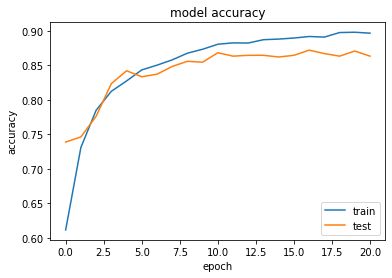

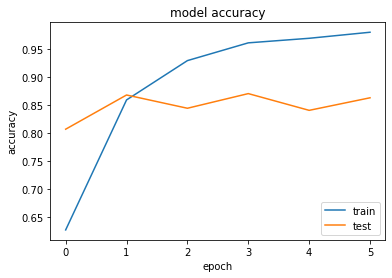

In [ ]:
target_names=['None','Support','Attack']
 
y_pred_SG=[]
y_true_SG=[]

# Assign one-hot encodings to Y values (0,1,2).
categorical_Y = to_categorical(Y_relation_type)

X_supporting_train, X_supporting_test = X_supporting[sections_train_set], X_supporting[sections_test_set]
X_supported_train, X_supported_test = X_supported[sections_train_set], X_supported[sections_test_set]
X_supporting_before_train, X_supporting_before_test = X_supporting_before[sections_train_set], X_supporting_before[sections_test_set]
X_supported_before_train, X_supported_before_test = X_supported_before[sections_train_set], X_supported_before[sections_test_set]
X_supporting_after_train, X_supporting_after_test = X_supporting_after[sections_train_set], X_supporting_after[sections_test_set]
X_supported_after_train, X_supported_after_test = X_supported_after[sections_train_set], X_supported_after[sections_test_set]
X_stat_train, X_stat_test = X_sentence_stat_dataframe[sections_train_set], X_sentence_stat_dataframe[sections_test_set]
Y_train, Y_test = categorical_Y[sections_train_set], categorical_Y[sections_test_set]

# Train the model.
model,model_stat=train_MultiModal(X_supporting_train,X_supported_train,X_supporting_before_train,X_supported_before_train,X_supporting_after_train,X_supported_after_train,X_stat_train,Y_train)

y_pred_temp=model.predict([X_supporting_test,X_supported_test,X_supporting_before_test,X_supported_before_test,X_supporting_after_test,X_supported_after_test,X_stat_test])
for i in range(len(Y_test)):
  y_pred_SG.append(np.argmax(y_pred_temp[i]))
  y_true_SG.append(np.argmax(Y_test[i].tolist()))

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true_SG, y_pred_SG, target_names=target_names))   

              precision    recall  f1-score   support

        None       0.92      0.85      0.88       319
     Support       0.88      0.95      0.91       542
      Attack       0.29      0.07      0.11        28

    accuracy                           0.89       889
   macro avg       0.69      0.62      0.64       889
weighted avg       0.87      0.89      0.88       889



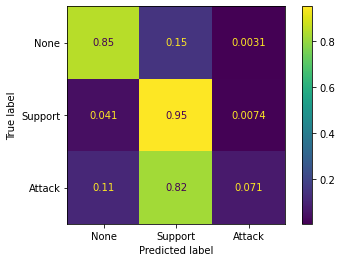

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true_SG, y_pred_SG,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()

## **Stat model results**

In [ ]:
y_pred=[]
y_true=[]

# Transform probabilities predicted in the most probable value (0 or 1).
y_pred_temp=model_stat.predict(X_stat_test).tolist()
for i in range(len(Y_test)):
  y_pred.append(np.argmax(y_pred_temp[i]))
  y_true.append(np.argmax(Y_test[i].tolist()))

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names)) 

              precision    recall  f1-score   support

        None       0.71      0.98      0.82       319
     Support       0.94      0.77      0.85       542
      Attack       0.00      0.00      0.00        28

    accuracy                           0.82       889
   macro avg       0.55      0.58      0.56       889
weighted avg       0.83      0.82      0.81       889



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


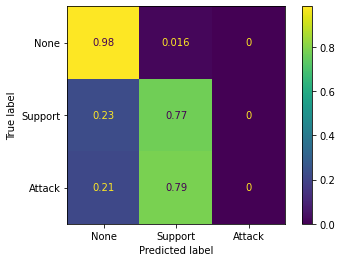

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()

# **Sentences predictions**

In [ ]:
# Gets in input the list of ture labels and predicted labels of the test set and returns
# two list.
# One of the list contain only if the prediction are write(1) or wrong(0).
# The other list contain also the indication of the tipe of mistake (true/false positive/negative).

def get_correct_predictions(y_true_list:list,y_pred_list:list):
  result_list=[]
  result_list_int=[]

  for i in range(0,len(y_true_list)):
    correct_prediction=""
    correct_prediction_int=1
    if y_pred_list[i]==0:
      if y_true_list[i]==0:
        correct_prediction="True none"
      else:
        if y_true_list[i]==1:
          correct_prediction="Support false none"
        else:
          correct_prediction="Attack false none"
        correct_prediction_int=0
    if y_pred_list[i]==1:
      if y_true_list[i]==1:
        correct_prediction="True support"
      else:
        if y_true_list[i]==0:
          correct_prediction="None false support"
        else:
          correct_prediction="Attack false support"
        correct_prediction_int=0
    if y_pred_list[i]==2:
      if y_true_list[i]==2:
        correct_prediction="True none"
      else:
        if y_true_list[i]==1:
          correct_prediction="Support false attack"
        else:
          correct_prediction="None false attack"
        correct_prediction_int=0    
    result_list.append(correct_prediction)
    result_list_int.append(correct_prediction_int)    

  return result_list, result_list_int

In [ ]:
# Create a list containing the correspondent value of true positive, ture negative,
# false positive and false negative, for the predicitons of the NN on the
# test sets of the two datset. 

# The correlation to select the feature to pass to the STC will be evaluated only 
# on the report of the presence of an error in each sentences (not considering the type
# of the error), sentence_prediction_int list.

sentence_prediction_SG, sentence_prediction_SG_int=get_correct_predictions(y_true_SG, y_pred_SG)

# Get the version of the dataset used containing only the element of the test set.
test_set_essay_dataset=relation_ann_dataset.iloc[sections_test_set]

# Get the list of the couples of sentences and argumentative sec. in the test set.
test_set_sentences_list_SG=["sentence 1: "+sentence_list[relation_ann_dataset.iloc[i]['supporting_sentence_id']]+"\n sentence 2 :"+sentence_list[relation_ann_dataset.iloc[i]['supported_sentence_id']] for i in sections_test_set]

# Get the list of all the sentences used in the test set.
test_set_sentence_id_list_SG=[]
for i in sections_test_set:
  test_set_sentence_id_list_SG.append(relation_ann_dataset.iloc[i]['supporting_sentence_id'])
  test_set_sentence_id_list_SG.append(relation_ann_dataset.iloc[i]['supported_sentence_id'])
  for j in range(0,relation_ann_dataset.iloc[i]['supporting_section_length']):
    test_set_sentence_id_list_SG.append(relation_ann_dataset.iloc[i]['supporting_sentence_id']+1+j)
  for j in range(0,relation_ann_dataset.iloc[i]['supported_section_length']):
    test_set_sentence_id_list_SG.append(relation_ann_dataset.iloc[i]['supported_sentence_id']+1+j)
test_set_sentence_id_list_SG=list(set(test_set_sentence_id_list_SG))

argumentative_test_set_sentences_list_SG=["section 1: "+relation_ann_dataset.iloc[i]['supporting_text']+"\n senction 2 :"+relation_ann_dataset.iloc[i]['supported_text'] for i in sections_test_set]
argument_test_set_sentences_list_SG=[relation_ann_dataset.iloc[i]['supporting_text'] for i in sections_test_set]
argument_test_set_sentences_list_SG+=[relation_ann_dataset.iloc[i]['supported_text'] for i in sections_test_set]

In [ ]:
test_set_essay_dataset.shape

(889, 10)

In [ ]:
len(sentence_prediction_SG)

889

In [ ]:
sentence_prediction_SG.count("True none")

273

In [ ]:
sentence_prediction_SG.count("Support false none")

22

In [ ]:
sentence_prediction_SG.count("Attack false none")

3

In [ ]:
sentence_prediction_SG.count("True support")

516

In [ ]:
sentence_prediction_SG.count("None false support")

47

In [ ]:
sentence_prediction_SG.count("Attack false support")

23

In [ ]:
sentence_prediction_SG.count("True attack")

0

In [ ]:
sentence_prediction_SG.count("Support false attack")

4

In [ ]:
sentence_prediction_SG.count("None false attack")

1

## **Correaltion scores**

In [ ]:
# Compute the sorted correlation scores.
# Takes in input a dataframe and a list of labels, returns the sorted (from higher to lower) 
# list of columns names and their correlation value.

def get_correlation_scores(dataframe: pd.DataFrame, labels: list)->list:
  correlation_scores= []

  columns=dataframe.columns
  for column in columns:
    correlation, p_value = spearmanr(dataframe[column].values, labels)
    # Correlation absolute value.
    correlation = np.abs(correlation)
    correlation_scores.append((correlation,column))

  # Sort the correlation scores of each word with the lable by the correlation score associated.
  correlation_scores=sorted(correlation_scores, key=lambda x: (x[0]), reverse=True)    

  return correlation_scores

## **POS preparation**

In [ ]:
# Separate each sentence in the list of POS TAG that compones them.
POS_sentence_list=[nltk.pos_tag(nltk.word_tokenize(sentence)) for sentence in sentence_list]

POS_sentence_list[0]

[('it', 'PRP'),
 ('is', 'VBZ'),
 ('always', 'RB'),
 ('said', 'VBD'),
 ('that', 'IN'),
 ('competition', 'NN'),
 ('can', 'MD'),
 ('effectively', 'RB'),
 ('promote', 'VB'),
 ('the', 'DT'),
 ('development', 'NN'),
 ('of', 'IN'),
 ('economy', 'NN')]

In [ ]:
# Create a version with the simplifyed version of the POS tag.

simplified_POS_sentence_list=[]

for POS_sentence in POS_sentence_list:
  simplified_POS_sentence_list.append([(word, map_tag('en-ptb', 'universal', tag)) for word, tag in POS_sentence]) 

In [ ]:
simplified_POS_sentence_list[0]

[('it', 'PRON'),
 ('is', 'VERB'),
 ('always', 'ADV'),
 ('said', 'VERB'),
 ('that', 'ADP'),
 ('competition', 'NOUN'),
 ('can', 'VERB'),
 ('effectively', 'ADV'),
 ('promote', 'VERB'),
 ('the', 'DET'),
 ('development', 'NOUN'),
 ('of', 'ADP'),
 ('economy', 'NOUN')]

In [ ]:
# Get the list of the sentences as POS tag from the list of the
# list of the POS tag of each sentence. 
def get_POS_sentence_list(POS_sentence_list: list)->list:
  POS_sentences=[]
  for POS_list in POS_sentence_list:
    sentence=""
    for word, tag in POS_list:
      sentence+=tag+" "
    POS_sentences.append(sentence)    

  return POS_sentences

In [ ]:
POS_sentences=get_POS_sentence_list(POS_sentence_list)
simple_POS_sentences=get_POS_sentence_list(simplified_POS_sentence_list)

POS_sentences[0]

'PRP VBZ RB VBD IN NN MD RB VB DT NN IN NN '

## **Customised Tokenizer**

In [ ]:
#  Lemmatization is used.
def build_tokenizer(text):

  wordnet_lemmatizer = WordNetLemmatizer()

  # Text tokenization.
  tokens=nltk.word_tokenize(text)

  # Text normalization throgh lemmatizzation.

  lemmas=[]
  for word in tokens:
    lemmas.append(wordnet_lemmatizer.lemmatize(word))

  return lemmas  

## **Bag of words**

In [ ]:
# Trasformation of the passed corpus in the dataframe of the bag of ngram contained
# in it.
def bag_of_ngram(sentence_list: list, ngram: int)-> pd.DataFrame:
  vectorizer=CountVectorizer(tokenizer=build_tokenizer,ngram_range=(ngram,ngram))
  bag_ngram=vectorizer.fit_transform(sentence_list)

  dataframe=pd.DataFrame(bag_ngram.toarray(), columns=vectorizer.get_feature_names())

  return dataframe

## **From BOW of sentences to BOW of common elements of two sentences** 

In [ ]:
def sum_lists(first_list:list,second_list)->list:
  
  resulting_list=[first_list[i]+second_list[i] for i in range(len(first_list))]

  return resulting_list

In [ ]:
# Takes two lists in input and returns a list which has in each position the
# number of common occurrencies of the elmenent in the same position in the original
# lists.
def elements_in_common(supporting:list,supported:list)->list:
  common_list=[]
  for i in range(len(supporting)):
      common_list.append(min(supporting[i],supported[i]))
  return common_list      

In [ ]:
# Takes in input the dataframe of the relations and a dataframe representing the
# Bag of word of a ceirtain representation of the text, and returns in output the
# dataframe containing for each relation the list of common words of the two sections.

def two_BOW_to_single_common_BOW(relations_dataframe:pd.DataFrame,BOW:pd.DataFrame)->pd.DataFrame:
  dataframe_relation_common_BOW_list=[]
  columns_names=BOW.columns

  for relation in relations_dataframe.itertuples():
    supporting_sentence=relation.supporting_sentence_id
    supported_sentence=relation.supported_sentence_id

    supporting_sentence_BOW=BOW.loc[supporting_sentence]
    supported_sentence_BOW=BOW.loc[supported_sentence]

    for i in range(relation.supporting_section_length):
      supporting_sentence_BOW=sum_lists(supporting_sentence_BOW,BOW.loc[supporting_sentence+i+1])

    for i in range(relation.supported_section_length):
      supported_sentence_BOW=sum_lists(supported_sentence_BOW,BOW.loc[supported_sentence+i+1])  

    dataframe_relation_common_BOW_list.append(elements_in_common(list(supporting_sentence_BOW),list(supported_sentence_BOW)))

  common_BOW_dataframe=pd.DataFrame(dataframe_relation_common_BOW_list,columns=columns_names)  
  return common_BOW_dataframe

In [ ]:
def two_BOW_to_single_common_BOW_arg_section(section_number:int,BOW:pd.DataFrame)->pd.DataFrame:
  dataframe_relation_common_BOW_list=[]
  columns_names=BOW.columns

  for i in range(section_number):

    dataframe_relation_common_BOW_list.append(elements_in_common(list(BOW.iloc[i]),list(BOW.iloc[i+section_number])))

  common_BOW_dataframe=pd.DataFrame(dataframe_relation_common_BOW_list,columns=columns_names)  
  return common_BOW_dataframe

## **POS Bigrams**

In [ ]:
# Get the BOW of the bigrams of the POS tag.

POS_bigrams=bag_of_ngram(POS_sentences,2)
simple_POS_bigrams=bag_of_ngram(simple_POS_sentences,2)

POS_bigrams=POS_bigrams.iloc[test_set_sentence_id_list_SG]
simple_POS_bigrams=simple_POS_bigrams.iloc[test_set_sentence_id_list_SG]

POS_bigrams.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,$ cc,$ cd,$ dt,$ in,$ jj,$ jjr,$ jjs,$ nn,$ nns,$ rb,$ vbg,$ vbn,'' ),"'' ,",'' dt,'' in,'' jj,'' jjr,'' nn,'' nns,'' rb,'' to,'' vbd,'' vbn,'' vbp,'' vbz,'' wp,'' wrb,( dt,( in,( jj,( nn,( nns,( prp,( vb,") ,",) in,) nns,) rb,) to,...,wdt vbp,wdt vbz,wdt wrb,wp $,"wp ,",wp dt,wp in,wp jj,wp md,wp nn,wp nnp,wp nns,wp prp,wp rb,wp to,wp vbd,wp vbp,wp vbz,"wrb ,",wrb cc,wrb cd,wrb dt,wrb ex,wrb in,wrb jj,wrb jjr,wrb jjs,wrb md,wrb nn,wrb nns,wrb pdt,wrb prp,wrb rb,wrb to,wrb vb,wrb vbd,wrb vbg,wrb vbn,wrb vbp,wrb vbz
2048,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6513,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Compute the correlation scores considering only the train test sentences.
POS_bigrams_common_BOW=two_BOW_to_single_common_BOW(test_set_essay_dataset,POS_bigrams)
simple_POS_bigrams_common_BOW=two_BOW_to_single_common_BOW(test_set_essay_dataset,simple_POS_bigrams)

In [ ]:
POS_bigrams_common_BOW.head()

,$ cc,$ cd,$ dt,$ in,$ jj,$ jjr,$ jjs,$ nn,$ nns,$ rb,$ vbg,$ vbn,'' ),"'' ,",'' dt,'' in,'' jj,'' jjr,'' nn,'' nns,'' rb,'' to,'' vbd,'' vbn,'' vbp,'' vbz,'' wp,'' wrb,( dt,( in,( jj,( nn,( nns,( prp,( vb,") ,",) in,) nns,) rb,) to,...,wdt vbp,wdt vbz,wdt wrb,wp $,"wp ,",wp dt,wp in,wp jj,wp md,wp nn,wp nnp,wp nns,wp prp,wp rb,wp to,wp vbd,wp vbp,wp vbz,"wrb ,",wrb cc,wrb cd,wrb dt,wrb ex,wrb in,wrb jj,wrb jjr,wrb jjs,wrb md,wrb nn,wrb nns,wrb pdt,wrb prp,wrb rb,wrb to,wrb vb,wrb vbd,wrb vbg,wrb vbn,wrb vbp,wrb vbz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**correlation score**

In [ ]:
correlation_scores_POS_bigram=get_correlation_scores(POS_bigrams_common_BOW,sentence_prediction_SG_int)
correlation_scores_simple_POS_bigram=get_correlation_scores(simple_POS_bigrams_common_BOW,sentence_prediction_SG_int)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
# Remove NaN values.
correlation_scores_POS_bigram=[correlation_score for correlation_score in correlation_scores_POS_bigram if not math.isnan(correlation_score[0])]
correlation_scores_POS_bigram[0:10]

[(0.020830512973704397, '$ jj'),
 (0.03705531796789716, '$ nn'),
 (0.017275937542544095, '$ nns'),
 (0.09426099477055785, ', ex'),
 (0.0582376594545594, ', jjs'),
 (0.05801849652072512, ', nns'),
 (0.037407260983199714, ', in'),
 (0.029542460113897103, ', rb'),
 (0.09426099477055785, ', to'),
 (0.023713717915634563, ', jj')]

In [ ]:
most_correlated_bigram_POS=[bigram[1] for bigram in correlation_scores_POS_bigram[0:100]]

In [ ]:
# Remove NaN values.
correlation_scores_simple_POS_bigram=[correlation_score for correlation_score in correlation_scores_simple_POS_bigram if not math.isnan(correlation_score[0])]
correlation_scores_simple_POS_bigram[0:10]

[(0.10048071424960421, '. adv'),
 (0.06528115686027693, '. noun'),
 (0.037407260983199714, '. adp'),
 (0.09426099477055785, '. prt'),
 (0.04142183663351755, '. det'),
 (0.08624030455290936, 'adv adp'),
 (0.08074591087770248, 'adp verb'),
 (0.09426099477055785, 'conj prt'),
 (0.08962300055834332, 'det noun'),
 (0.06318556625155662, 'noun det')]

In [ ]:
most_correlated_bigram_simple_POS=[bigram[1] for bigram in correlation_scores_simple_POS_bigram[0:100]]

## **Bag of words and Bigrams correlation**

In [ ]:
bag_words_dataframe=bag_of_ngram(sentence_list, 1)
bag_bigrams_dataframe=bag_of_ngram(sentence_list, 2)

bag_words_dataframe=bag_words_dataframe.iloc[test_set_sentence_id_list_SG]
bag_bigrams_dataframe=bag_bigrams_dataframe.iloc[test_set_sentence_id_list_SG]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
bag_words_dataframe.head()

,!,%,&,','','3,'a,'cult,'dug,'globalization,'halo,'innovate,'ll,'low,'m,'re,'s,'social,'teachers,'this,'ve,'your,(,),",",-,--,.,...,0,1,10,100,10000,14,15,16,170,17th,18,...,wrap,write,writer,writing,written,wrong,wrongly,wrote,x,yahoo,yandex,yang,year,yearly,yell,yellow,yet,yield,yielding,york,you,young,younger,youngster,your,yours,yourself,youth,zappa,zeal,zero,zone,zoo,zookeepers,zoology,–,‘,’,“,”
2048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6513,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
bag_bigrams_dataframe.head()

,"% ,",% country,% excellent,% in,% of,& study,"' ,",' ability,' accommodation,' accomplishment,' achievement,' acquisition,' acted,' adventurousness,' aim,' art,' attention,' attitude,' basic,' behavior,' benefit,' confidence,' control,' creation,' criticism,' culture,' current,' deeper,' development,' economic,' education,' effectiveness,' enthusiasm,' environment,' expectation,' experience,' family,' friend,' future,' hardship,...,zoo ha,zoo have,zoo is,zoo just,zoo kept,zoo not,zoo offer,zoo play,zoo preserve,zoo provide,zoo serve,zoo should,zoo than,zoo they,zoo to,zoo towards,zoo where,zoo will,zoo would,zoo you,"zookeepers ,",zookeepers have,zoology argue,– the,– these,– this,‘ ha,‘ trong,’ bay,’ civil,’ culture,’ drum,’ duty,’ health,’ m,’ s,’ solid,’ t,“ knowledge,” ha
2048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6513,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_common_bag_words_dataframe=two_BOW_to_single_common_BOW(test_set_essay_dataset,bag_words_dataframe)
train_common_bag_bigrams_dataframe=two_BOW_to_single_common_BOW(test_set_essay_dataset,bag_bigrams_dataframe)

In [ ]:
train_common_bag_words_dataframe.head()

,!,%,&,','','3,'a,'cult,'dug,'globalization,'halo,'innovate,'ll,'low,'m,'re,'s,'social,'teachers,'this,'ve,'your,(,),",",-,--,.,...,0,1,10,100,10000,14,15,16,170,17th,18,...,wrap,write,writer,writing,written,wrong,wrongly,wrote,x,yahoo,yandex,yang,year,yearly,yell,yellow,yet,yield,yielding,york,you,young,younger,youngster,your,yours,yourself,youth,zappa,zeal,zero,zone,zoo,zookeepers,zoology,–,‘,’,“,”
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Select the 50 words/bigram most correlated to the output (correlation computed considering 
# only the train test).

correlation_scores_words=get_correlation_scores(train_common_bag_words_dataframe,sentence_prediction_SG_int)
correlation_scores_bigram=get_correlation_scores(train_common_bag_bigrams_dataframe,sentence_prediction_SG_int)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
correlation_scores_words=[correlation_score for correlation_score in correlation_scores_words if not math.isnan(correlation_score[0])]
correlation_scores_words[0:10]

[(0.09426099477055785, 'leaving'),
 (0.09426099477055785, 'studying'),
 (0.0582376594545594, 'best'),
 (0.0207159432886134, "'"),
 (0.05415209909164036, "'s"),
 (0.017811588589134293, ','),
 (0.1333802998828661, ';'),
 (0.008314506875601771, 'a'),
 (0.0582376594545594, 'able'),
 (0.008563276949450022, 'about')]

In [ ]:
most_correlated_word=[word[1] for word in correlation_scores_words[0:100]]

In [ ]:
correlation_scores_bigram=[correlation_score for correlation_score in correlation_scores_bigram if not math.isnan(correlation_score[0])]
correlation_scores_bigram[0:10]

[(0.011946894140755114, "' accomplishment"),
 (0.011946894140755114, "' mistake"),
 (0.011946894140755114, "' personality"),
 (0.09426099477055785, "'s future"),
 (0.0582376594545594, "'s health"),
 (0.011946894140755114, "'s life"),
 (0.011946894140755114, "'s mistake"),
 (0.011946894140755114, "'s part"),
 (0.011946894140755114, "'s revenue"),
 (0.09426099477055785, "'s undeniable")]

In [ ]:
most_correlated_bigram=[bigram[1] for bigram in correlation_scores_bigram[0:100]]

## **Argumentative sections: Bag of words correlation**

In [ ]:
a_bag_words_dataframe=bag_of_ngram(argument_test_set_sentences_list_SG, 1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
test_set_essay_dataset.shape[0]

889

In [ ]:
a_bag_words_dataframe.shape[0]-test_set_essay_dataset.shape[0]

889

In [ ]:
a_train_common_bag_words_dataframe=two_BOW_to_single_common_BOW_arg_section(test_set_essay_dataset.shape[0],a_bag_words_dataframe)

In [ ]:
a_train_common_bag_words_dataframe.head()

,%,','','s,'teachers,'this,'ve,'your,",",-,.,1,10,15,1969,1st,2,2030,370,40,4:00,99,:,;,``,a,ability,able,about,above,abroad,absence,absolutely,absorb,absorbed,abstract,academic,accelarates,accelerate,accept,...,wild,wildlife,will,win,window,wing,wish,with,within,without,witnessed,woman,wonderful,word,wore,work,worked,worker,working,workplace,world,worldwide,worsens,worth,worthwhile,would,writer,writing,written,wrong,year,you,young,youngster,your,zappa,zoo,–,’,“
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
a_correlation_scores_words=get_correlation_scores(a_train_common_bag_words_dataframe,sentence_prediction_SG_int)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
a_correlation_scores_words=[correlation_score for correlation_score in a_correlation_scores_words if not math.isnan(correlation_score[0])]
a_correlation_scores_words[0:10]

[(0.016904980973747288, "'"),
 (0.03512314717498663, "'s"),
 (0.009219986933360687, ','),
 (0.015503181521761505, 'a'),
 (0.026774438269542927, 'about'),
 (0.016904980973747288, 'accommodation'),
 (0.016904980973747288, 'activity'),
 (0.016904980973747288, 'after'),
 (0.03392489699381936, 'agriculture'),
 (0.011946894140755114, 'air')]

In [ ]:
a_most_correlated_word=[word[1] for word in a_correlation_scores_words[0:100]]

# **STC**

In [ ]:
# Read the datasets retrieved by the Stab and Gurevych dataset.

statistic=pd.read_csv('relation_statistic.csv')
statistic=statistic.iloc[sections_test_set]
statistic.reset_index(drop=True, inplace=True)

POS=pd.read_csv('relation_POS.csv')
POS=POS.iloc[sections_test_set]
POS.reset_index(drop=True, inplace=True)

simple_POS=pd.read_csv('relation_simple_POS.csv')
simple_POS=simple_POS.iloc[sections_test_set]
simple_POS.reset_index(drop=True, inplace=True)

bigram_POS=POS_bigrams_common_BOW[most_correlated_bigram_POS]
bigram_POS.reset_index(drop=True, inplace=True)

bigram_simple_POS=simple_POS_bigrams_common_BOW[most_correlated_bigram_simple_POS]
bigram_simple_POS.reset_index(drop=True, inplace=True)

dependency=pd.read_csv('relation_dependency.csv')
dependency=dependency.iloc[sections_test_set]
dependency.reset_index(drop=True, inplace=True)

dependency_tree_stat=pd.read_csv('relation_dependency_tree_stat.csv')
dependency_tree_stat=dependency_tree_stat.iloc[sections_test_set]
dependency_tree_stat.reset_index(drop=True, inplace=True)

named_entity=pd.read_csv('relation_named_entity_BOW.csv')
named_entity=named_entity.iloc[sections_test_set]
named_entity.reset_index(drop=True, inplace=True)

BOW=train_common_bag_words_dataframe[most_correlated_word]
BOW.reset_index(drop=True, inplace=True)

Bigram=train_common_bag_bigrams_dataframe[most_correlated_bigram]
Bigram.reset_index(drop=True, inplace=True)

imported_ngram=pd.read_csv('relation_imported_ngram.csv')
imported_ngram=imported_ngram.iloc[sections_test_set]
imported_ngram.reset_index(drop=True, inplace=True)

others=pd.read_csv('relation_remaining_stat.csv')
others=others.iloc[sections_test_set]
others.reset_index(drop=True, inplace=True)

a_BOW=a_train_common_bag_words_dataframe[a_most_correlated_word]
a_BOW.reset_index(drop=True, inplace=True)

In [ ]:
statistic.shape

(889, 3)

In [ ]:
bigram_POS.shape

(889, 100)

In [ ]:
# Remove data types that are not categorical.
statistic=statistic.drop(columns=['length_sentence_ratio'])
others=others.drop(columns=['supported: type token ratio'])
others=others.drop(columns=['supporting: type token ratio'])
statistic=statistic.round(0)
statistic=statistic.abs()
others=others.round(0)

In [ ]:
# Combine the dataframe of the type of data used in the NN and of the data not 
# used.
dataframe_non_used=statistic
dataframe_non_used=pd.concat([dataframe_non_used,POS], axis=1)
print(dataframe_non_used.shape)
dataframe_non_used=pd.concat([dataframe_non_used,simple_POS], axis=1)
print(dataframe_non_used.shape)
dataframe_non_used=pd.concat([dataframe_non_used,imported_ngram], axis=1)
print(dataframe_non_used.shape)
dataframe_non_used=pd.concat([dataframe_non_used,others], axis=1)
print(dataframe_non_used.shape)
dataframe_non_used=pd.concat([dataframe_non_used,bigram_POS], axis=1)
print(dataframe_non_used.shape)
dataframe_non_used=pd.concat([dataframe_non_used,bigram_simple_POS], axis=1)
print(dataframe_non_used.shape)
dataframe_non_used=pd.concat([dataframe_non_used,BOW], axis=1)
print(dataframe_non_used.shape)

dataframe_used=dependency
dataframe_used=pd.concat([dataframe_used,dependency_tree_stat], axis=1)
print(dataframe_used.shape)
dataframe_used=pd.concat([dataframe_used,Bigram], axis=1)
print(dataframe_used.shape)
dataframe_used=pd.concat([dataframe_used,named_entity], axis=1)
print(dataframe_used.shape)

(889, 41)
(889, 53)
(889, 93)
(889, 95)
(889, 195)
(889, 289)
(889, 389)
(889, 48)
(889, 148)
(889, 165)


In [ ]:
dataframe_used.shape

(889, 165)

In [ ]:
sentence_predictions_SG = pd.DataFrame(data={'argumentative': sentence_prediction_SG})

## **Learning**

In [ ]:
# Divide the items in a train and a test set.
list_index=[i for i in range(others.shape[0])]

train_index,test_index=train_test_split(list_index,test_size=0.2, random_state=32)

In [ ]:
pos_attackFnone=-1
pos_supportFnone=-1
pos_attackFsupport=-1
pos_noneFsupport=-1
pos_supportFattack=-1
pos_noneFattack=-1
count=0
instance_attackFnone=""
instance_supportFnone=""
instance_attackFsupport=""
instance_noneFsupport=""
instance_supportFattack=""
instance_noneFattack=""
sec_instance_attackFnone=""
sec_instance_supportFnone=""
sec_instance_attackFsupport=""
sec_instance_noneFsupport=""
sec_instance_supportFattack=""
sec_instance_noneFattack=""

for i in test_index:
  if sentence_prediction_SG[i]=='Attack false none':
    instance_attackFnone=test_set_sentences_list_SG[i]
    sec_instance_attackFnone=argumentative_test_set_sentences_list_SG[i]
    pos_attackFnone=count
  if sentence_prediction_SG[i]=='Support false none':
    instance_supportFnone=test_set_sentences_list_SG[i]
    sec_instance_supportFnone=argumentative_test_set_sentences_list_SG[i]
    pos_supportFnone=count
  if sentence_prediction_SG[i]=='Support false attack':
    instance_supportFattack=test_set_sentences_list_SG[i]
    sec_instance_supportFattack=argumentative_test_set_sentences_list_SG[i]
    pos_supportFattack=count
  if sentence_prediction_SG[i]=='None false support':
    instance_noneFsupport=test_set_sentences_list_SG[i]
    sec_instance_noneFsupport=argumentative_test_set_sentences_list_SG[i]
    pos_noneFsupport=count
  if sentence_prediction_SG[i]=='None false attack':
    instance_noneFattack=test_set_sentences_list_SG[i]
    sec_instance_noneFattack=argumentative_test_set_sentences_list_SG[i]
    pos_noneFattack=count
  if sentence_prediction_SG[i]=='Attack false support':
    instance_attackFsupport=test_set_sentences_list_SG[i]
    sec_instance_attackFsupport=argumentative_test_set_sentences_list_SG[i]
    pos_attackFsupport=count        
  if not (pos_attackFsupport==-1 or pos_noneFattack==-1 or pos_noneFsupport==-1 or pos_supportFattack==-1 or pos_supportFnone==-1 or pos_attackFnone==-1):
    break
  count+=1  

print(instance_attackFsupport)
print(instance_noneFattack)
print(instance_noneFsupport)
print(instance_supportFattack)
print(instance_supportFnone)
print(instance_attackFnone)
print(sec_instance_attackFsupport)
print(sec_instance_noneFattack)
print(sec_instance_noneFsupport)
print(sec_instance_supportFattack)
print(sec_instance_supportFnone)
print(sec_instance_attackFnone)
print(pos_attackFsupport)
print(pos_noneFattack)
print(pos_noneFsupport)
print(pos_supportFattack)
print(pos_supportFnone)
print(pos_attackFnone)

sentence 1: but a more efficient and reliable system can also be invented to guarantee the private information of users 
 sentence 2 :there is panic among people that their conversation can be intercepted by the third party 

sentence 1: first and foremost , carbon emission cut is significantly essential for protecting the atmosphere 
 sentence 2 :obviously , the policy that concentrates money on developing public transportation brings an advantageous impact on earth 
sentence 1: however , most entertaining movies are empty and nonsensical 
 sentence 2 :first , most serious movies have a wide variety of content 
sentence 1: it enables to improve learners ' spelling capacity and accompany reading or writing disabilities as well 
 sentence 2 :firstly , this approach is a basis tool used in several fields such as taking notes , doing homework and writing 

section 1: a more efficient and reliable system can also be invented to guarantee the private information of users
 senction 2 :There 

In [ ]:
# The method takes in input a dataframe containing the data from which to predict
# the output and the output labels desired and returns, the label for the 
# test set, the probabilities of the predicted classes, and the global and local 
# explanations of which features are most usefoul in predicting the labels.

def stc_procedure(dataframe:pd.DataFrame,label:pd.DataFrame):
  dataframe['argumentative']=label['argumentative'].tolist()

  STC = SparseTensorClassifier(targets=['argumentative'], features=dataframe.columns[:-1])

  STC.fit(dataframe.iloc[train_index])

  STC.set({"entropy": 1, "balance": 0.9, "power": 1})

  global_explainability = STC.explain()

  labels, probability, explainability = STC.predict(dataframe.iloc[test_index])

  ground_labels=dataframe['argumentative'].iloc[test_index]

  return ground_labels, global_explainability, labels, probability, explainability

## **Not used stat dataframe**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(dataframe_non_used,sentence_predictions_SG)

In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.8089887640449438
f1 score: 0.21680735930735934
precision: 0.22564269746646798
recall: 0.21180783093053734


In [ ]:
global_explainability_tabular.loc["Attack false none"][:25]

,features,score
argumentative,,
Attack false none,",: 4",0.003240
Attack false none,chat: 1,0.001736
Attack false none,.: 5,0.001736
Attack false none,pron adv: 1,0.001736
Attack false none,cc to: 1,0.001736
Attack false none,det noun: 6,0.001736
Attack false none,verb adp: 4,0.001736
Attack false none,. prt: 1,0.001736
Attack false none,noun .: 4,0.001736


In [ ]:
global_explainability_tabular.loc["Support false none"][:25]

,features,score
argumentative,,
Support false none,",: 0",0.000800
Support false none,cc vbz: 1,0.000560
Support false none,conj verb: 1,0.000525
Support false none,position_in_essay_distance: 1,0.000461
Support false none,adp noun: 1,0.000419
Support false none,det: 0,0.000381
Support false none,in: 1,0.000378
Support false none,adp: 1,0.000378
Support false none,dt: 0,0.000373


In [ ]:
global_explainability_tabular.loc["Attack false support"][:25]

,features,score
argumentative,,
Attack false support,ex vbp: 1,0.000750
Attack false support,",: 0",0.000687
Attack false support,ex: 1,0.000637
Attack false support,advantage: 1,0.000588
Attack false support,in jj: 1,0.000557
Attack false support,adp adj: 1,0.000555
Attack false support,", wp: 1",0.000534
Attack false support,dt nns: 1,0.000505
Attack false support,position_in_essay_distance: 0,0.000478


In [ ]:
global_explainability_tabular.loc["Support false attack"][:25]

,features,score
argumentative,,
Support false attack,", dt: 1",0.001747
Support false attack,artist: 1,0.001405
Support false attack,adv prt: 1,0.001339
Support false attack,. det: 1,0.001273
Support false attack,noun: 3,0.000779
Support false attack,in: 0,0.000682
Support false attack,adp: 0,0.000682
Support false attack,position_in_essay_distance: 2,0.000584
Support false attack,md: 1,0.000561


In [ ]:
global_explainability_tabular.loc["None false attack"][:25]

,features,score
argumentative,,
None false attack,conj adj: 1,0.002899
None false attack,noun: 1,0.001966
None false attack,adv .: 1,0.001333
None false attack,in: 0,0.000916
None false attack,adp: 0,0.000916
None false attack,verb: 1,0.000916
None false attack,jj nns: 1,0.000857
None false attack,position_in_essay_distance: 2,0.000785
None false attack,nn: 0,0.000737


In [ ]:
global_explainability_tabular.loc["None false support"][:25]

,features,score
argumentative,,
None false support,",: 0",0.000680
None false support,",: 2",0.000505
None false support,position_in_essay_distance: 1,0.000384
None false support,position_in_essay_distance: 2,0.000361
None false support,adp noun: 1,0.000327
None false support,noun noun: 1,0.000323
None false support,. det: 1,0.000303
None false support,det noun: 0,0.000298
None false support,and: 1,0.000296


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:15]

features         score
item argumentative                                  
140  Attack false support         ,: 0  3.533612e-06
     Attack false support    in nns: 1  1.117901e-06
     Attack false support  adp noun: 1  8.007587e-07
     Attack false support       can: 1  7.852578e-07
     Attack false support  noun adp: 1  6.252555e-07
     Attack false support      conj: 0  5.645595e-07
     Attack false support        cc: 0  5.645595e-07
     Attack false support  conj adj: 0  5.407397e-07
     Attack false support       det: 2  5.310728e-07
     Attack false support        md: 1  5.230387e-07
     Attack false support     adv .: 0  5.150183e-07
     Attack false support  det noun: 0  5.114324e-07
     Attack false support    jj nns: 0  4.894885e-07
     Attack false support      noun: 3  4.843440e-07
     Attack false support     dt nn: 0  4.375877e-07

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:15]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:15]

features         score
item argumentative                                 
158  None false support       noun: 4  6.927754e-07
     None false support         in: 1  6.490359e-07
     None false support        adp: 1  6.490359e-07
     None false support      dt nn: 1  6.488852e-07
     None false support       verb: 2  6.434851e-07
     None false support   conj adj: 0  5.668130e-07
     None false support       conj: 0  5.547950e-07
     None false support         cc: 0  5.547950e-07
     None false support        det: 1  5.235080e-07
     None false support         vb: 0  5.233853e-07
     None false support  noun verb: 1  4.703054e-07
     None false support     jj nns: 0  4.678178e-07
     None false support         md: 0  4.668423e-07
     None false support   det noun: 1  4.366730e-07
     None false support          ,: 1  3.987447e-07

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:15]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:15]

features         score
item argumentative                                                  
139  Support false none                           ,: 0  4.111735e-06
     Support false none  position_in_essay_distance: 1  1.184938e-06
     Support false none                         det: 0  9.799870e-07
     Support false none                          in: 1  9.726515e-07
     Support false none                         adp: 1  9.726515e-07
     Support false none                          dt: 0  9.580907e-07
     Support false none                         and: 1  9.489714e-07
     Support false none                    det noun: 0  7.651365e-07
     Support false none                       adv .: 0  5.693148e-07
     Support false none                          cc: 1  5.354814e-07
     Support false none                        conj: 1  5.354814e-07
     Support false none                          md: 0  5.146588e-07
     Support false none                    conj adj: 0  5.096588e-07
     Support false none                   noun verb: 0  5.041620e-07
     Support false none                          vb: 0  4.980001e-07

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:15]

## **Used stat dataframe**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(dataframe_used,sentence_predictions_SG)

In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.5224719101123596
f1 score: 0.13543376912942132
precision: 0.1345486111111111
recall: 0.14825660768894713


In [ ]:
global_explainability_tabular.loc["Attack false none"][:25]

,features,score
argumentative,,
Attack false none,", or: 1",0.003757
Attack false none,dep: 1,0.003757
Attack false none,punct: 5,0.003757
Attack false none,; however: 1,0.003757
Attack false none,", to: 1",0.003757
Attack false none,ccomp: 3,0.003433
Attack false none,det: 6,0.003433
Attack false none,", we: 1",0.003181
Attack false none,pobj: 6,0.002999


In [ ]:
global_explainability_tabular.loc["Support false none"][:25]

,features,score
argumentative,,
Support false none,det: 0,0.000819
Support false none,punct: 0,0.000744
Support false none,supporting: max number of children of a ROOT n...,0.000741
Support false none,supported: max number of children of a ROOT no...,0.000665
Support false none,advmod: 0,0.000650
Support false none,supporting: tree depth: 3,0.000644
Support false none,supported: tree depth: 9,0.000571
Support false none,prep: 5,0.000550
Support false none,", i: 1",0.000510


In [ ]:
global_explainability_tabular.loc["Attack false support"][:25]

,features,score
argumentative,,
Attack false support,expl: 1,0.001429
Attack false support,", what: 1",0.001271
Attack false support,a job: 1,0.001154
Attack false support,mark: 2,0.001132
Attack false support,supported: max number of children of a ROOT no...,0.001111
Attack false support,mark: 1,0.001029
Attack false support,nsubj: 3,0.000932
Attack false support,neg: 1,0.000709
Attack false support,supporting: max number of children of a ROOT n...,0.000707


In [ ]:
global_explainability_tabular.loc["Support false attack"][:25]

,features,score
argumentative,,
Support false attack,neg: 1,0.001303
Support false attack,prep: 0,0.000842
Support false attack,pobj: 0,0.000788
Support false attack,supported: tree depth: 3,0.000711
Support false attack,supporting: tree depth: 3,0.000678
Support false attack,supporting: max number of children of a ROOT n...,0.000511
Support false attack,cc: 0,0.000492
Support false attack,conj: 0,0.000491
Support false attack,supporting: max number of children of a ROOT n...,0.000483


In [ ]:
global_explainability_tabular.loc["None false attack"][:25]

,features,score
argumentative,,
None false attack,supported: tree depth: 7,0.003634
None false attack,supported: max number of children of a ROOT no...,0.003161
None false attack,advmod: 2,0.003015
None false attack,supporting: tree depth: 3,0.001822
None false attack,supporting: max number of children of a ROOT n...,0.001760
None false attack,det: 0,0.001449
None false attack,prep: 0,0.001132
None false attack,pobj: 0,0.001059
None false attack,cc: 1,0.001028


In [ ]:
global_explainability_tabular.loc["None false support"][:25]

,features,score
argumentative,,
None false support,advmod: 2,0.001066
None false support,pobj: 2,0.000849
None false support,nsubj: 2,0.000800
None false support,det: 0,0.000768
None false support,punct: 0,0.000651
None false support,supported: max number of children of a ROOT no...,0.000508
None false support,advcl: 1,0.000502
None false support,supported: max number of children of a ROOT no...,0.000479
None false support,supporting: max number of children of a ROOT n...,0.000477


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:15]

features         score
item argumentative                                                                        
140  Attack false support                                           punct: 0  3.766521e-06
     Attack false support                                              cc: 0  2.883536e-06
     Attack false support                                            conj: 0  2.699893e-06
     Attack false support                                         auxpass: 1  2.218488e-06
     Attack false support                                             det: 1  2.084412e-06
     Attack false support                                             aux: 1  1.536107e-06
     Attack false support                                            dobj: 0  1.535673e-06
     Attack false support                                           nsubj: 0  1.359911e-06
     Attack false support                                          advmod: 0  1.328451e-06
     Attack false support                                            pobj: 1  1.225273e-06
     Attack false support                                            prep: 1  1.067382e-06
     Attack false support                                       nsubjpass: 1  1.023937e-06
     Attack false support  supporting: max number of children of a ROOT n...  9.591167e-07
     Attack false support  supported: max number of children of a ROOT no...  9.017637e-07
     Attack false support                           supported: tree depth: 4  8.022243e-07

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:15]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:15]

features         score
item argumentative                                                                      
158  None false support                                              cc: 0  2.833663e-06
     None false support                                            conj: 0  2.735740e-06
     None false support                                            amod: 0  1.932742e-06
     None false support                                             aux: 0  1.867356e-06
     None false support                                            pobj: 0  1.816140e-06
     None false support                                            prep: 1  1.678273e-06
     None false support                                          advmod: 1  1.636188e-06
     None false support                           supported: tree depth: 6  1.599088e-06
     None false support                                             det: 1  1.589031e-06
     None false support                                            dobj: 1  1.395183e-06
     None false support                                           pcomp: 1  1.345292e-06
     None false support                                            mark: 0  1.074785e-06
     None false support  supported: max number of children of a ROOT no...  9.452447e-07
     None false support                                           nsubj: 1  8.313771e-07
     None false support                          supporting: tree depth: 5  7.751562e-07

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:15]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:15]

features         score
item argumentative                                                                      
139  Support false none                                             det: 0  4.962177e-06
     Support false none                                           punct: 0  4.507970e-06
     Support false none                                              cc: 1  2.639974e-06
     Support false none                                             aux: 0  2.132143e-06
     Support false none                                            prep: 0  1.938966e-06
     Support false none                                            amod: 0  1.755409e-06
     Support false none                                            dobj: 2  1.395856e-06
     Support false none                                            pobj: 0  1.360842e-06
     Support false none                                           nsubj: 1  1.349736e-06
     Support false none  supported: max number of children of a ROOT no...  1.322116e-06
     Support false none  supporting: max number of children of a ROOT n...  1.296524e-06
     Support false none                                            mark: 0  1.136953e-06
     Support false none                                        compound: 1  1.089519e-06
     Support false none                          supporting: tree depth: 6  6.981070e-07
     Support false none                                          advmod: 1  4.670489e-07

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:15]

## **Statistic dataframe**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(statistic,sentence_predictions_SG)

In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.33707865168539325
f1 score: 0.13809055118110236
precision: 0.20283681961313543
recall: 0.19868801878549586


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,position_in_essay_distance: 1,0.052926
Support false none,position_in_essay_distance: 6,0.025152
Support false none,position_in_essay_distance: 8,0.019205
Support false none,paragraph distance: 0,0.013308
Support false none,position_in_essay_distance: 4,0.011445
Support false none,position_in_essay_distance: 5,0.010525
Support false none,position_in_essay_distance: 2,0.006366


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,position_in_essay_distance: 0,0.054846
Attack false support,position_in_essay_distance: 1,0.033692
Attack false support,position_in_essay_distance: 3,0.024050
Attack false support,paragraph distance: 0,0.013376
Attack false support,position_in_essay_distance: 4,0.010929
Attack false support,position_in_essay_distance: 5,0.010050
Attack false support,position_in_essay_distance: 2,0.006079


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,position_in_essay_distance: 1,0.044146
None false support,position_in_essay_distance: 2,0.041418
None false support,paragraph distance: 0,0.014372
None false support,position_in_essay_distance: 3,0.012605
None false support,position_in_essay_distance: 0,0.011498
None false support,position_in_essay_distance: 6,0.006294
None false support,position_in_essay_distance: 4,0.005728


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features     score
item argumentative                                                
140  Attack false support          paragraph distance: 0  0.006688
     Attack false support  position_in_essay_distance: 2  0.003039

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

,,features,score
item,argumentative,,
158,None false support,paragraph distance: 0,0.007186


In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features     score
item argumentative                                              
139  Support false none  position_in_essay_distance: 1  0.026463
     Support false none          paragraph distance: 0  0.006654

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **POS dataframe**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(POS,sentence_predictions_SG)

In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.5056179775280899
f1 score: 0.09994308480364257
precision: 0.11141851106639838
recall: 0.1075524246395806


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,",: 0",0.003396
Support false none,in: 1,0.002998
Support false none,dt: 0,0.002954
Support false none,rb: 0,0.002267
Support false none,prp: 2,0.002011
Support false none,cc: 1,0.001651
Support false none,md: 0,0.001587
Support false none,vb: 0,0.001535
Support false none,cc: 0,0.001481


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,ex: 1,0.005050
Attack false support,md: 2,0.003688
Attack false support,",: 0",0.002919
Attack false support,in: 4,0.002745
Attack false support,vbp: 1,0.002449
Attack false support,jj: 6,0.002116
Attack false support,wp: 1,0.002045
Attack false support,jjs: 1,0.002004
Attack false support,vbz: 1,0.001957


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,",: 0",0.002890
None false support,in: 2,0.002275
None false support,dt: 0,0.002217
None false support,vbn: 1,0.002162
None false support,",: 2",0.002144
None false support,in: 1,0.002001
None false support,cc: 0,0.001710
None false support,nn: 0,0.001652
None false support,jjr: 1,0.001635


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features     score
item argumentative                          
140  Attack false support     ,: 0  0.000075
     Attack false support    cc: 0  0.000045
     Attack false support    md: 1  0.000041
     Attack false support   vbn: 1  0.000030
     Attack false support    vb: 1  0.000026

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features     score
item argumentative                        
158  None false support    in: 1  0.000051
     None false support    cc: 0  0.000044
     None false support    vb: 0  0.000041
     None false support    md: 0  0.000037
     None false support   nns: 0  0.000031

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features     score
item argumentative                        
139  Support false none     ,: 0  0.000087
     Support false none    in: 1  0.000077
     Support false none    dt: 0  0.000076
     Support false none    cc: 1  0.000042
     Support false none    md: 0  0.000041

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **Simple POS dataframe**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(simple_POS,sentence_predictions_SG)

In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.47752808988764045
f1 score: 0.11388241172551632
precision: 0.13312933869199853
recall: 0.10833060288335518


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,.: 0,0.009816
Support false none,det: 0,0.008727
Support false none,adp: 1,0.008662
Support false none,pron: 2,0.006940
Support false none,noun: 3,0.006775
Support false none,verb: 1,0.005926
Support false none,adv: 0,0.005503
Support false none,verb: 2,0.004907
Support false none,conj: 1,0.004769


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,verb: 5,0.008608
Attack false support,.: 0,0.008436
Attack false support,adp: 4,0.007929
Attack false support,verb: 1,0.005658
Attack false support,adj: 6,0.005522
Attack false support,adp: 3,0.005439
Attack false support,pron: 3,0.005320
Attack false support,conj: 0,0.005027
Attack false support,noun: 7,0.004785


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,.: 0,0.008351
None false support,adp: 2,0.006571
None false support,det: 0,0.006551
None false support,noun: 4,0.006169
None false support,adp: 1,0.005780
None false support,verb: 2,0.005730
None false support,adj: 4,0.005404
None false support,conj: 0,0.004941
None false support,.: 2,0.004851


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features     score
item argumentative                          
140  Attack false support     .: 0  0.000703
     Attack false support  conj: 0  0.000419
     Attack false support   det: 2  0.000394
     Attack false support  noun: 3  0.000359
     Attack false support   adv: 0  0.000234

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features     score
item argumentative                        
158  None false support  noun: 4  0.000514
     None false support   adp: 1  0.000482
     None false support  verb: 2  0.000478
     None false support  conj: 0  0.000412
     None false support   det: 1  0.000388

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features     score
item argumentative                        
139  Support false none     .: 0  0.000818
     Support false none   det: 0  0.000727
     Support false none   adp: 1  0.000722
     Support false none  conj: 1  0.000397
     Support false none  noun: 4  0.000316

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **bigram POS dataframe**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(bigram_POS,sentence_predictions_SG)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.43820224719101125
f1 score: 0.11003032809484423
precision: 0.16430623973727423
recall: 0.13648154215814765


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,cc vbz: 1,0.001902
Support false none,nn in: 2,0.000966
Support false none,in nn: 1,0.000807
Support false none,$ jj: 1,0.000800
Support false none,cc vb: 1,0.000754
Support false none,dt nn: 1,0.000685
Support false none,in vbg: 1,0.000679
Support false none,jj nns: 0,0.000637
Support false none,jj nns: 1,0.000617


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,ex vbp: 1,0.002546
Attack false support,in jj: 1,0.001890
Attack false support,", wp: 1",0.001812
Attack false support,dt nns: 1,0.001714
Attack false support,in nns: 1,0.001477
Attack false support,cc prp: 1,0.001434
Attack false support,in vbg: 1,0.001298
Attack false support,in dt: 1,0.001157
Attack false support,jj in: 1,0.001078


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,jj nns: 1,0.000926
None false support,dt nn: 1,0.000857
None false support,", dt: 1",0.000846
None false support,in dt: 1,0.000741
None false support,in prp: 1,0.000671
None false support,nn in: 2,0.000645
None false support,jj nns: 0,0.000618
None false support,"nn ,: 1",0.000605
None false support,in nn: 1,0.000566


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features     score
item argumentative                            
140  Attack false support  in nns: 1  0.000015
     Attack false support  jj nns: 0  0.000006
     Attack false support   dt nn: 0  0.000006
     Attack false support   nn md: 1  0.000005
     Attack false support   dt jj: 1  0.000003

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features     score
item argumentative                          
158  None false support   dt nn: 1  0.000009
     None false support  jj nns: 0  0.000006
     None false support   in dt: 0  0.000002
     None false support    , dt: 0  0.000002
     None false support  in vbg: 1  0.000002

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features     score
item argumentative                          
139  Support false none  jj nns: 0  0.000006
     Support false none   dt nn: 0  0.000005
     Support false none   nn cc: 1  0.000003
     Support false none   in dt: 0  0.000002
     Support false none    , dt: 0  0.000002

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **Bigram simple POS dataframe**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(bigram_simple_POS,sentence_predictions_SG)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.5056179775280899
f1 score: 0.10563040040887385
precision: 0.14729064039408865
recall: 0.1448162407164701


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,conj verb: 1,0.001886
Support false none,adp noun: 1,0.001506
Support false none,det noun: 0,0.001069
Support false none,noun noun: 1,0.001031
Support false none,verb noun: 1,0.000850
Support false none,pron adj: 1,0.000846
Support false none,adv .: 0,0.000795
Support false none,noun adp: 2,0.000740
Support false none,conj adj: 1,0.000735


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,adp adj: 1,0.001993
Attack false support,verb adp: 1,0.001596
Attack false support,conj pron: 1,0.001516
Attack false support,. pron: 1,0.001384
Attack false support,adp det: 1,0.001382
Attack false support,adp verb: 1,0.001335
Attack false support,det verb: 1,0.001206
Attack false support,adv adp: 1,0.001119
Attack false support,adp noun: 1,0.001118


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,adp noun: 1,0.001172
None false support,noun noun: 1,0.001161
None false support,. det: 1,0.001086
None false support,det noun: 0,0.001070
None false support,adv adp: 1,0.000978
None false support,adp det: 1,0.000869
None false support,pron noun: 1,0.000845
None false support,adv .: 0,0.000796
None false support,conj adj: 0,0.000792


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features     score
item argumentative                              
140  Attack false support  adp noun: 1  0.000012
     Attack false support  noun adp: 1  0.000009
     Attack false support  conj adj: 0  0.000008
     Attack false support     adv .: 0  0.000008
     Attack false support  det noun: 0  0.000008

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features     score
item argumentative                             
158  None false support   conj adj: 0  0.000008
     None false support  noun verb: 1  0.000007
     None false support   det noun: 1  0.000006
     None false support   adj noun: 0  0.000005
     None false support      adv .: 1  0.000005

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features     score
item argumentative                             
139  Support false none   det noun: 0  0.000011
     Support false none      adv .: 0  0.000008
     Support false none   conj adj: 0  0.000008
     Support false none  noun verb: 0  0.000007
     Support false none  verb noun: 2  0.000006

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **Dependency BOW dataframe**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(dependency,sentence_predictions_SG)

In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.5449438202247191
f1 score: 0.12908653846153845
precision: 0.15651608325449384
recall: 0.1560998252512014


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,det: 0,0.002690
Support false none,punct: 0,0.002444
Support false none,advmod: 0,0.002137
Support false none,prep: 5,0.001806
Support false none,pobj: 1,0.001623
Support false none,pobj: 5,0.001503
Support false none,cc: 1,0.001431
Support false none,conj: 1,0.001404
Support false none,relcl: 1,0.001349


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,expl: 1,0.004696
Attack false support,mark: 2,0.003718
Attack false support,mark: 1,0.003383
Attack false support,nsubj: 3,0.003063
Attack false support,neg: 1,0.002330
Attack false support,pobj: 2,0.002192
Attack false support,ccomp: 2,0.002163
Attack false support,advcl: 1,0.002100
Attack false support,punct: 0,0.002042


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,advmod: 2,0.003503
None false support,pobj: 2,0.002790
None false support,nsubj: 2,0.002630
None false support,det: 0,0.002524
None false support,punct: 0,0.002140
None false support,advcl: 1,0.001651
None false support,cc: 0,0.001536
None false support,conj: 0,0.001483
None false support,prep: 2,0.001416


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features     score
item argumentative                             
140  Attack false support    punct: 0  0.000046
     Attack false support       cc: 0  0.000036
     Attack false support     conj: 0  0.000033
     Attack false support  auxpass: 1  0.000027
     Attack false support      det: 1  0.000026

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features     score
item argumentative                        
158  None false support    cc: 0  0.000035
     None false support  conj: 0  0.000034
     None false support  amod: 0  0.000024
     None false support   aux: 0  0.000023
     None false support  pobj: 0  0.000022

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features     score
item argumentative                         
139  Support false none    det: 0  0.000061
     Support false none  punct: 0  0.000056
     Support false none     cc: 1  0.000033
     Support false none    aux: 0  0.000026
     Support false none   prep: 0  0.000024

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **Dependency tree stat**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(dependency_tree_stat,sentence_predictions_SG)

In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.28651685393258425
f1 score: 0.0685483870967742
precision: 0.08279220779220779
recall: 0.058486238532110095


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,supporting: max number of children of a ROOT n...,0.021064
Support false none,supported: max number of children of a ROOT no...,0.018903
Support false none,supporting: tree depth: 3,0.018301
Support false none,supported: tree depth: 9,0.016241
Support false none,supported: tree depth: 6,0.011994
Support false none,supported: tree depth: 4,0.011826
Support false none,supporting: max number of children of a ROOT n...,0.010440
Support false none,supported: max number of children of a ROOT no...,0.009613
Support false none,supporting: tree depth: 10,0.007373


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,supported: max number of children of a ROOT no...,0.031587
Attack false support,supporting: max number of children of a ROOT n...,0.020114
Attack false support,supported: tree depth: 9,0.015509
Attack false support,supported: tree depth: 7,0.013944
Attack false support,supporting: tree depth: 6,0.012511
Attack false support,supported: tree depth: 6,0.011453
Attack false support,supporting: max number of children of a ROOT n...,0.008713
Attack false support,supporting: tree depth: 7,0.008676
Attack false support,supporting: tree depth: 5,0.007931


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,supported: max number of children of a ROOT no...,0.014433
None false support,supported: max number of children of a ROOT no...,0.013627
None false support,supporting: max number of children of a ROOT n...,0.013554
None false support,supported: tree depth: 3,0.013454
None false support,supported: max number of children of a ROOT no...,0.012712
None false support,supporting: tree depth: 7,0.012125
None false support,supported: tree depth: 8,0.012063
None false support,supporting: tree depth: 6,0.011475
None false support,supported: tree depth: 4,0.009864


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features     score
item argumentative                                                                    
140  Attack false support  supporting: max number of children of a ROOT n...  0.001125
     Attack false support  supported: max number of children of a ROOT no...  0.001058
     Attack false support                           supported: tree depth: 4  0.000941
     Attack false support                          supporting: tree depth: 4  0.000550

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features     score
item argumentative                                                                  
158  None false support                           supported: tree depth: 6  0.001876
     None false support  supported: max number of children of a ROOT no...  0.001109
     None false support                          supporting: tree depth: 5  0.000909
     None false support  supporting: max number of children of a ROOT n...  0.000885

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features     score
item argumentative                                                                  
139  Support false none  supported: max number of children of a ROOT no...  0.001551
     Support false none  supporting: max number of children of a ROOT n...  0.001521
     Support false none                          supporting: tree depth: 6  0.000819

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **Named entity**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(named_entity,sentence_predictions_SG)

In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.6123595505617978
f1 score: 0.1637976004173187
precision: 0.15841269841269842
recall: 0.19291539245667688


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,date: 0,1.894566e-04
Support false none,org: 0,3.427048e-06
Support false none,language: 0,8.665811e-07
Support false none,norp: 0,8.473447e-07
Support false none,cardinal: 0,8.375408e-07
Support false none,ordinal: 0,1.388486e-07
Support false none,time: 0,3.461686e-08
Support false none,person: 0,3.446456e-08
Support false none,fac: 0,0.000000e+00


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,date: 0,1.904309e-04
Attack false support,org: 0,3.444672e-06
Attack false support,language: 0,8.710375e-07
Attack false support,norp: 0,8.517022e-07
Attack false support,cardinal: 0,8.418478e-07
Attack false support,ordinal: 0,1.395626e-07
Attack false support,time: 0,3.479487e-08
Attack false support,person: 0,3.464180e-08
Attack false support,fac: 0,0.000000e+00


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,org: 1,2.930515e-03
None false support,norp: 1,1.935900e-03
None false support,language: 1,1.777464e-03
None false support,cardinal: 1,1.386185e-03
None false support,date: 0,2.046034e-04
None false support,org: 0,3.520497e-06
None false support,language: 0,9.130370e-07
None false support,norp: 0,8.927693e-07
None false support,cardinal: 0,8.824399e-07


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features         score
item argumentative                                  
140  Attack false support      date: 0  1.120182e-05
     Attack false support       org: 0  2.026277e-07
     Attack false support  language: 0  5.123750e-08
     Attack false support      norp: 0  5.010013e-08
     Attack false support  cardinal: 0  4.952046e-08

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features         score
item argumentative                                
158  None false support      date: 0  1.203549e-05
     None false support       org: 0  2.070880e-07
     None false support  language: 0  5.370806e-08
     None false support      norp: 0  5.251584e-08
     None false support  cardinal: 0  5.190823e-08

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features         score
item argumentative                                
139  Support false none      date: 0  1.114451e-05
     Support false none       org: 0  2.015911e-07
     Support false none  language: 0  5.097536e-08
     Support false none      norp: 0  4.984381e-08
     Support false none  cardinal: 0  4.926710e-08

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **BOW**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(BOW,sentence_predictions_SG)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.4550561797752809
f1 score: 0.16391161457240755
precision: 0.13432661200073248
recall: 0.3138925294888598


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,",: 0",0.001455
Support false none,and: 1,0.001254
Support false none,citizen: 1,0.000800
Support false none,at: 1,0.000483
Support false none,child: 1,0.000445
Support false none,a: 2,0.000306
Support false none,",: 1",0.000134
Support false none,can: 0,0.000042
Support false none,chat: 0,0.000039


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,advantage: 1,0.001995
Attack false support,a: 1,0.001507
Attack false support,child: 1,0.001274
Attack false support,",: 0",0.001251
Attack false support,leaving: 1,0.001069
Attack false support,studying: 1,0.001069
Attack false support,always: 1,0.001069
Attack false support,best: 1,0.001069
Attack false support,be: 2,0.001069


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,",: 0",0.001238
None false support,and: 1,0.001004
None false support,",: 2",0.000919
None false support,a: 1,0.000658
None false support,can: 1,0.000544
None false support,;: 1,0.000460
None false support,chinese: 1,0.000446
None false support,car: 1,0.000446
None false support,are: 1,0.000433


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features         score
item argumentative                                
140  Attack false support       ,: 0  1.250737e-05
     Attack false support     can: 1  1.037329e-05
     Attack false support      be: 1  3.950315e-06
     Attack false support    chat: 0  3.894567e-07
     Attack false support  around: 0  3.894567e-07

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features         score
item argumentative                              
158  None false support       ,: 1  1.411374e-06
     None false support    chat: 0  4.184413e-07
     None false support  around: 0  4.184413e-07
     None false support  affect: 0  4.178721e-07
     None false support    able: 0  4.178721e-07

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features         score
item argumentative                              
139  Support false none       ,: 0  1.455366e-05
     Support false none     and: 1  1.253595e-05
     Support false none     can: 0  4.219165e-07
     Support false none    chat: 0  3.874641e-07
     Support false none  around: 0  3.874641e-07

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **Bigrams**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(Bigram,sentence_predictions_SG)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.5786516853932584
f1 score: 0.1619732785200411
precision: 0.15765004226542687
recall: 0.181301878549585


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,", i: 1",8.001542e-04
Support false none,; however: 0,3.874641e-05
Support false none,", to: 0",3.874641e-05
Support false none,", or: 0",3.874641e-05
Support false none,", we: 0",3.859192e-05
Support false none,", it: 0",3.806624e-05
Support false none,", what: 0",3.055268e-06
Support false none,a job: 0,3.037651e-06
Support false none,", i: 0",7.674716e-07


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,", what: 1",0.001995
Attack false support,a job: 1,0.001812
Attack false support,natural balance: 1,0.001069
Attack false support,a long: 1,0.001069
Attack false support,", there: 1",0.001069
Attack false support,", studying: 1",0.001069
Attack false support,'s future: 1,0.001069
Attack false support,a supplementary: 1,0.001069
Attack false support,'s undeniable: 1,0.001069


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,a special: 1,0.000560
None false support,", humaneness: 1",0.000560
None false support,; moreover: 1,0.000560
None false support,", the: 1",0.000557
None false support,'s health: 1,0.000446
None false support,", which: 1",0.000361
None false support,a a: 1,0.000334
None false support,", it: 1",0.000245
None false support,", they: 1",0.000242


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features         score
item argumentative                                   
140  Attack false support  ; however: 0  3.894567e-07
     Attack false support       , to: 0  3.894567e-07
     Attack false support       , or: 0  3.894567e-07
     Attack false support       , we: 0  3.879038e-07
     Attack false support       , it: 0  3.443579e-07

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features         score
item argumentative                                 
158  None false support  ; however: 0  4.184413e-07
     None false support       , to: 0  4.184413e-07
     None false support       , or: 0  4.184413e-07
     None false support       , we: 0  4.167729e-07
     None false support       , it: 0  4.010690e-07

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features         score
item argumentative                                 
139  Support false none  ; however: 0  3.874641e-07
     Support false none       , to: 0  3.874641e-07
     Support false none       , or: 0  3.874641e-07
     Support false none       , we: 0  3.859192e-07
     Support false none       , it: 0  3.806624e-07

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **Imported n-grams**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(imported_ngram,sentence_predictions_SG)

In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.5730337078651685
f1 score: 0.12363636363636364
precision: 0.10240963855421686
recall: 0.1559633027522936


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,for: 1,9.892294e-04
Support false none,for: 0,1.002496e-05
Support false none,so: 0,1.773529e-06
Support false none,because: 0,1.004441e-06
Support false none,moreover: 0,3.986565e-07
Support false none,hence: 0,3.914564e-07
Support false none,since: 0,1.040248e-07
Support false none,due to: 0,4.001123e-09
Support false none,furthermore: 0,4.001123e-09


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,so: 1,1.174727e-03
Attack false support,for: 1,9.446007e-04
Attack false support,for: 0,1.013579e-05
Attack false support,so: 0,1.693517e-06
Attack false support,because: 0,1.009607e-06
Attack false support,moreover: 0,4.007066e-07
Attack false support,hence: 0,3.934694e-07
Attack false support,since: 0,1.045597e-07
Attack false support,due to: 0,4.021699e-09


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,moreover: 1,1.278323e-03
None false support,hence: 1,1.017183e-03
None false support,because: 1,5.542391e-04
None false support,for: 1,2.475368e-04
None false support,for: 0,1.180501e-05
None false support,so: 0,1.915320e-06
None false support,because: 0,1.058288e-06
None false support,moreover: 0,4.200277e-07
None false support,hence: 0,4.124417e-07


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features         score
item argumentative                                  
140  Attack false support       for: 0  2.533946e-07
     Attack false support        so: 0  4.233792e-08
     Attack false support   because: 0  2.524017e-08
     Attack false support  moreover: 0  1.001766e-08
     Attack false support     hence: 0  9.836736e-09

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features         score
item argumentative                                
158  None false support       for: 0  2.951253e-07
     None false support        so: 0  4.788300e-08
     None false support   because: 0  2.645719e-08
     None false support  moreover: 0  1.050069e-08
     None false support     hence: 0  1.031104e-08

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features         score
item argumentative                                
139  Support false none       for: 0  2.506240e-07
     Support false none        so: 0  4.433822e-08
     Support false none   because: 0  2.511103e-08
     Support false none  moreover: 0  9.966412e-09
     Support false none     hence: 0  9.786409e-09

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **Subjectivity**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(others,sentence_predictions_SG)

In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.10112359550561797
f1 score: 0.03103448275862069
precision: 0.0625
recall: 0.020642201834862386


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,supported: subjectivity score: 1.0,0.020510
Support false none,supported: subjectivity score: 0.0,0.015694
Support false none,supporting: subjectivity score: 1.0,0.012879
Support false none,supporting: subjectivity score: 0.0,0.004834


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,supported: subjectivity score: 0.0,0.021646
Attack false support,supported: subjectivity score: 1.0,0.013709
Attack false support,supporting: subjectivity score: 1.0,0.010761
Attack false support,supporting: subjectivity score: 0.0,0.005455


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,supported: subjectivity score: 1.0,0.024634
None false support,supporting: subjectivity score: 1.0,0.016919
None false support,supported: subjectivity score: 0.0,0.014836
None false support,supporting: subjectivity score: 0.0,0.004399


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features     score
item argumentative                                                      
140  Attack false support   supported: subjectivity score: 1.0  0.006855
     Attack false support  supporting: subjectivity score: 0.0  0.002728

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features     score
item argumentative                                                    
158  None false support  supporting: subjectivity score: 1.0  0.008460
     None false support   supported: subjectivity score: 0.0  0.007418

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features     score
item argumentative                                                    
139  Support false none   supported: subjectivity score: 0.0  0.007847
     Support false none  supporting: subjectivity score: 0.0  0.002417

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]

## **Argument section BOW**

In [ ]:
ground_labels, global_explainability_tabular, labels, probability, explainability=stc_procedure(a_BOW,sentence_predictions_SG)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
accuracy=accuracy_score(ground_labels, labels)
f1_score_value=f1_score(y_true=ground_labels, y_pred=labels, average='macro')
precision=precision_score(ground_labels, labels, average='macro')
recall=recall_score(ground_labels, labels, average='macro')

In [ ]:
print('accuracy: {}'.format(accuracy))
print('f1 score: {}'.format(f1_score_value))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

accuracy: 0.5056179775280899
f1 score: 0.22369186369186367
precision: 0.22708410370187762
recall: 0.3068479685452163


In [ ]:
#global_explainability_tabular.loc["Attack false none"][:15]

In [ ]:
global_explainability_tabular.loc["Support false none"][:15]

,features,score
argumentative,,
Support false none,and: 1,0.001276
Support false none,control: 1,0.001120
Support false none,discrimination: 1,0.000953
Support false none,computer: 1,0.000953
Support false none,custom: 1,0.000862
Support false none,education: 1,0.000862
Support false none,experience: 1,0.000791
Support false none,at: 1,0.000791
Support false none,child: 1,0.000754


In [ ]:
global_explainability_tabular.loc["Attack false support"][:15]

,features,score
argumentative,,
Attack false support,co-operation: 1,0.001069
Attack false support,could: 1,0.001069
Attack false support,can: 1,0.000658
Attack false support,do: 1,0.000581
Attack false support,a: 1,0.000474
Attack false support,be: 1,0.000458
Attack false support,class: 1,0.000408
Attack false support,animal: 1,0.000297
Attack false support,are: 1,0.000292


In [ ]:
#global_explainability_tabular.loc["Support false attack"][:15]

In [ ]:
#global_explainability_tabular.loc["None false attack"][:15]

In [ ]:
global_explainability_tabular.loc["None false support"][:15]

,features,score
argumentative,,
None false support,",: 1",0.000992
None false support,and: 1,0.000894
None false support,can: 1,0.000690
None false support,'s: 1,0.000595
None false support,factor: 1,0.000560
None false support,a: 3,0.000560
None false support,chinese: 1,0.000560
None false support,car: 1,0.000560
None false support,carbon: 1,0.000446


In [ ]:
explainability.loc[(pos_attackFsupport,'Attack false support')][0:5]

features         score
item argumentative                                       
140  Attack false support            can: 1  6.584180e-06
     Attack false support             be: 1  4.583307e-06
     Attack false support    development: 0  3.884447e-07
     Attack false support  environmental: 0  3.884447e-07
     Attack false support       economic: 0  3.879038e-07

In [ ]:
#explainability.loc[(pos_noneFattack,'None false attack')][0:5]

In [ ]:
explainability.loc[(pos_noneFsupport,'None false support')][0:5]

features         score
item argumentative                                     
158  None false support    development: 0  4.173540e-07
     None false support  environmental: 0  4.173540e-07
     None false support       economic: 0  4.167729e-07
     None false support         artist: 0  4.162306e-07
     None false support            can: 0  3.639086e-07

In [ ]:
#explainability.loc[(pos_supportFattack,'Support false attack')][0:5]

In [ ]:
explainability.loc[(pos_supportFnone,'Support false none')][0:5]

features         score
item argumentative                                     
139  Support false none            and: 1  1.276219e-05
     Support false none    development: 0  3.864574e-07
     Support false none  environmental: 0  3.864574e-07
     Support false none       economic: 0  3.859192e-07
     Support false none         artist: 0  3.854171e-07

In [ ]:
#explainability.loc[(pos_attackFnone,'Attack false none')][0:5]